# Оптимизация потребления электроэнергии
## Аналитический проект с применением AI
#### Оглавление<a id="0"></a>
- [Введение](#00)
 - [Описание задачи](#01)
 - [Описание техпроцесса](#02)
 - [Описание данных](#03)
- [Подготовка к работе](#1)
 - [Загрузка библиотек и настройки](#11)
 - [Обзор данных](#12)
- [Исследовательский анализ](#2)
 - [Электроды](#21)
 - [Гранулированный сплав (объем материала)](#22)
 - [Гранулированный сплав (время добавления)](#23)
 - [Порошковая проволока (объем материала)](#24)
 - [Порошковая проволока (время добавления)](#25)
 - [Продувочный газ](#26)
 - [Температура плавки](#27)
 - [Объединение данных](#28)
- [Разработка модели регрессии](#3)
 - [Подготовка данных](#31)
 - [Автоматизация](#32)
 - [Константная модель](#33)
 - [Линейная регрессия](#34)
 - [Случайный лес](#35)
 - [Бустинг: XGBoost](#36)
 - [Бустинг: LightGBM](#37)
 - [Нейросеть](#38)
 - [Итоги разработки](#39)
- [Тестирование лучшей модели](#4)
- [Исследование важности признаков](#5)
- [Заключение](#6)

<a id="00"></a>
#### Задача<a id="01"></a>
Разработать модель, которая будет предсказывать температуру сплава в заключении процесса плавки стали. Достижение результата важно для снижения расходов электроэнергии и оптимизации расходов заказчика.   
В процессе разработки модели будет решена задача регрессии. Заказчиком установлено требование к целевой метрике - MAE (средняя абсолютная ошибка) не ниже $6.8$. В приложении к данному проекту это означает, что в среднем модель должна ошибаться не более чем на $6.8°C$. 


#### Процесс обработки<a id="02"></a>
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.   
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.   
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.   
Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).   

#### Описание данных<a id="03"></a>
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:  
`steel.data_arc` — данные об электродах;  
`steel.data_bulk` — данные об объёме сыпучих материалов;  
`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;  
`steel.data_gas` — данные о продувке сплава газом;  
`steel.data_temp` — данные об измерениях температуры;  
`steel.data_wire` — данные об объёме проволочных материалов;  
`steel.data_wire_time` — данные о времени подачи проволочных материалов.  


- Таблица `steel.data_arc`
    - key — номер партии;
    - BeginHeat — время начала нагрева;
    - EndHeat — время окончания нагрева;
    - ActivePower — значение активной мощности;
    - ReactivePower — значение реактивной мощности.
- Таблица `steel.data_bulk`
    - key — номер партии;
    - Bulk1 … Bulk15 — объём подаваемого материала.
- Таблица `steel.data_bulk_time`
    - key — номер партии;
    - Bulk1 … Bulk15 — время подачи материала.
- Таблица `steel.data_gas`
    - key — номер партии;
    - gas — объём подаваемого газа.
- Таблица `steel.data_temp`
    - key — номер партии;
    - MesaureTime — время замера;
    - Temperature — значение температуры.
- Таблица `steel.data_wire`
    - key — номер партии;
    - Wire1 … Wire15 — объём подаваемых проволочных материалов.
- Таблица `steel.data_wire_time`
    - key — номер партии;
    - Wire1 … Wire15 — время подачи проволочных материалов.  


Cтолбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.  


- [К оглавлению](#0)  

In [276]:
from IPython.display import HTML

HTML('''<script>
        code_show=true; 
        function code_toggle() {
            if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show
            } 
        $( document ).ready(code_toggle);
        </script>''')
        
def hide_code():
    return HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Нажми, чтобы показать / скрыть код"></form>''')

## Подготовка к работе<a id="1"></a>   
#### Загрузка библиотек, установка настроек<a id="11"></a>

In [277]:
hide_code()

In [1]:
!pip install scikit-learn==1.1.3 --user --quiet
import sklearn

try:
    import lightgbm    
    if int(lightgbm.__version__.split('.')[0]) < 4:
        !pip install -U lightgbm --quiet
except ModuleNotFoundError:
    !pip install -U lightgbm --quiet   

try:
    import xgboost    
    if int(xgboost.__version__.split('.')[1]) < 7:
        !pip install -U xgboost --quiet
except ModuleNotFoundError:
    !pip install -U xgboost --quiet
    
try:
    import statsmodels    
    if int(statsmodels.__version__.split('.')[1]) < 14:
        !pip install -U statsmodels --quiet
except ModuleNotFoundError:
    !pip install -U statsmodels --quiet

try:
    import tensorflow
except ModuleNotFoundError:
    !pip install tensorflow==2.13.0 --quiet

try:
    import optuna
    if int(optuna.__version__.split('.')[0]) < 3 and int(optuna.__version__.split('.')[1]) > 0:
        !pip install optuna==3.0.* --quiet
except ModuleNotFoundError:
    !pip install optuna==3.0.* --quiet
    import optuna
    
try:  
    from sqlalchemy import create_engine
except ModuleNotFoundError:
    !pip install sqlalchemy --quiet
    from sqlalchemy import create_engine
    
try:  
    import shap
except ModuleNotFoundError:
    !pip install shap --quiet 
    import shap
    
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
except ModuleNotFoundError:
    !pip install plotly --quiet
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
        
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn --quiet
    import seaborn as sns
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    !pip install tqdm --quiet
    from tqdm.notebook import tqdm
    
try:  
    import phik
except ModuleNotFoundError:
    !pip install phik --quiet
    import phik
    
try:  
    import scipy
except ModuleNotFoundError:
    !pip install scipy --quiet    

In [2]:
import os
import re
import time
import random
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from statsmodels.stats.stattools import medcouple
from scipy.special import boxcox, inv_boxcox
from scipy import stats as st

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder, RobustScaler, FunctionTransformer

from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import random as tf_random

from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False
shap.initjs()

In [3]:
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

MAE_THRESHOLD = 6.8

# настройки случайного состояния
RANDOM_STATE = 260722
np.random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
tf_random.set_seed(RANDOM_STATE)

# графические настройки
def set_seaborn_style(background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color, "figure.facecolor": background_color,        
        "axes.labelcolor": text_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "grid.color": grid_color,   
        
        "text.color": text_color,
        
        "xtick.color": text_color,
        "ytick.color": text_color,
        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,
        
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.spines.right": True,
        "axes.spines.top": True,
    }
)
    
set_seaborn_style(
        background_color="#ffffff",
        grid_color="#ded9d7",
        text_color="black"
    )

COLORSET = ['#f74316', '#d92323', '#1967b5', '#8fc3e3', '#300505']

tables_list = [ 'data_arc',
                'data_bulk',
                'data_bulk_time',
                'data_gas',
                'data_temp',
                'data_wire',
                'data_wire_time' ]

CMAP1 = sns.color_palette(f"dark:{COLORSET[0]}", as_cmap=True)

# настройски подключения к БД
db_config = {
            'user': 'praktikum_student',
            'pwd': 'Sdf4$2;d-d30pp',
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432,
            'db': 'data-science-final'
            }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

В данном разделе:
- загружены необходимые для работы библиотеки
- установлены настройки:
    - подключения к базе данных
    - случайного состояния
    - библиотеки Pandas
    - графические карты Seaborn  


- [К оглавлению](#0)  

#### Обзор данных<a id="12"></a>  

Проведем первичный обзор данных, отправив несколько запросов к БД.

In [7]:
def read(table, columns='*', query_add='t'):
    
    if columns != '*' or 'COUNT' in columns:
        if 'COUNT' in columns:
            columns = columns
        elif type(columns) == str:
            columns = '"'+columns+'"'
        elif type(columns) == list:
            columns = re.sub(r'\b(\w+)\b', r'"\1"', ','.join(columns))
        else:
            print('pass column or columns')
    
    query = f'''SELECT {columns} FROM steel.{table} {query_add}'''
    
    return pd.read_sql_query(query, con=engine)

for table in tables_list:
    display(read(table, query_add='LIMIT 3').style.set_caption(table))
    print(f"Количество наблюдений: {read(table, 'COUNT(1)')['count'].ravel()[0]}")
    print()

Все таблицы, заявленные заказчиком, есть в наличии и доступны.

In [9]:
# скачивание таблиц в Pandas - названия переменных
# для сохранения таблиц через globals()
# берутся из строковых названий таблиц в переменной table_name

for table_name in tables_list:
    globals()[table_name] = read(table_name)

В разделе:
- Проведен первичный обзор таблиц-источников.
- В заключении, данные загружены в таблицы Pandas, и готовы к дальнейшему анализу.     


- [К оглавлению](#0)  

## Исследовательский анализ<a id="2"></a>

In [272]:
hide_code()

In [267]:
def column_names_lower(data):
    '''
    функция для приведения имен колонок к snake_case
    '''
    columns = [re.sub(r'([a-z])([A-Z])', r'\1_\2', c).lower() for c in data.columns]
    return columns

def report_initial(data):
    '''
    вывод основных данных о датафрейме
    
    '''
    print(data.info())
    display(data.head())
    print(data.shape)
    print(f"Дубликатов: {data_arc.duplicated().sum()}")
    
def plt_single_distrib(data, label, color=COLORSET[0]):
    '''
    График распределения для одного признака
    '''

    fig, ax = plt.subplots(2, 1, figsize=(10, 4), height_ratios=[5.5, 1], sharex=True)
    
    if len(data.unique())  > 20:
        discrete = False
    else:
        discrete = True

    sns.histplot(x=data, color=color, ax=ax[0], discrete=discrete)
    sns.boxplot(x=data, color=color, orient='h', ax=ax[1])

    plt.yticks([])
    plt.xlabel(label)

    plt.sca(ax[0])
    plt.ylabel('')

    plt.title(label.split(' (')[0] + '\n(распределение значений)')
    plt.text(x=0.98, y=0.95, s=f'medcouple (скошенность данных):\n{medcouple(data):.3f}...',
         fontsize=9, ha='right', c=COLORSET[4], va='top', transform=ax[0].transAxes)
    
    
    plt.subplots_adjust(hspace = 0.02)
    plt.show()
    plt.close()
    
def fast_aggregation(data, column, new_column_name, how='mean'):
    '''
    быстрая аггрегация
    '''
    
    return (
        data_arc
            .groupby('key', as_index=False, dropna=False)
            .agg({column: how})
            .rename(columns={column: new_column_name})
    )

def plt_pair_boxplot(data1, data2):
    '''
    два боксплота (не парных) для 2 разных признаков
    '''
    fig, ax = plt.subplots(2, 1, figsize=(10, 1.5), sharex=False)

    sns.boxplot(x=data1, color=COLORSET[0], orient='h', ax=ax[0])
    sns.boxplot(x=data2, color=COLORSET[0], orient='h', ax=ax[1])

    plt.ylabel(data2.name, rotation=0, labelpad=55)
    plt.yticks([])
    

    plt.sca(ax[0])
    ax[0] = plt.gca()
    ax[0].xaxis.tick_top()
    ax[0].xaxis.set_label_position('top')

    plt.ylabel(data1.name, rotation=0, labelpad=50)
    plt.yticks([])

    plt.subplots_adjust(hspace = 0.05)
    plt.show()
    plt.close()
    
def plt_corr(data, drop_columns, category_columns=None):
    '''
    мартица корреляции
    '''
    
    plt.figure(figsize=(10, 10))
    df_corr = data.drop(drop_columns, axis=1)
    if category_columns is not None:
        corr = df_corr.phik_matrix(
            interval_cols=df_corr.drop(
                category_columns, axis=1
            )
        )
    else:
        corr = df_corr.phik_matrix()
    mask = np.triu(np.ones_like(corr, dtype='bool'))

    ax = sns.heatmap(corr, linewidths=2, annot=True, mask=mask,
                     annot_kws={'size': 8}, fmt='.2f', cbar=False,
                     cmap=CMAP1)

    ax.yaxis.get_ticklabels()[0].set_color('w')
    ax.yaxis.get_ticklabels()[-1].set_color(COLORSET[0])
    ax.xaxis.get_ticklabels()[-1].set_color('w')

    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.show()
    plt.close()
    
def plt_qq(data):
    
    '''
    проверка на нормальность:
    qq-plot и распределение признаков
    '''
    fig, ax = plt.subplots(1, 2, figsize=(8, 5), sharey=True, width_ratios=[5, 3],)

    osm, osr = st.probplot(data, fit=False)

    sns.lineplot(x=osm, y=osr, color=COLORSET[1], lw=3, alpha=.9, ax=ax[0])
    sns.lineplot(x=[np.min(osm), np.max(osm)], y=[np.min(osr), np.max(osr)], color=COLORSET[4], lw=.8, ax=ax[0])
    sns.histplot(y = data, color=COLORSET[1], ax=ax[1])
    
    ax[1] = plt.gca()
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    plt.xlabel('')
    plt.sca(ax[0])
    plt.xlabel('Теоретические квантили')
    plt.ylabel('Температура')
    plt.tight_layout()
    plt.show()
    plt.close()

def shapiro_test(data):  
    '''
    проверка на нормальность:
    тест шапиро-уилка
    '''
    results = st.shapiro(data)
    p_value = results[1]
    print('p-значение: ', p_value)
    if p_value < .05:
        print('Распределение не отвечает критериям нормальности')
    else:
        print('Данные распределены нормально')

#### Электроды<a id="21"></a>
Проведем анализ данных о нагреве сплава

In [ ]:
hide_code()

In [262]:
data_arc.columns = column_names_lower(data_arc)
report_initial(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14872 entries, 0 to 14871
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   key                        14872 non-null  int64         
 1   begin_heat                 14872 non-null  datetime64[ns]
 2   end_heat                   14872 non-null  datetime64[ns]
 3   active_power               14872 non-null  float64       
 4   reactive_power             14872 non-null  float64       
 5   begin_heat_first           14872 non-null  datetime64[ns]
 6   end_heat_last              14872 non-null  datetime64[ns]
 7   heat_iter_duration         14872 non-null  int32         
 8   cooldown_iter_duration     14872 non-null  float64       
 9   iterations_amount          14872 non-null  int64         
 10  total_active_power         14872 non-null  float64       
 11  total_reactive_power       14872 non-null  float64       
 12  heat

,key,begin_heat,end_heat,active_power,reactive_power,begin_heat_first,end_heat_last,heat_iter_duration,cooldown_iter_duration,iterations_amount,total_active_power,total_reactive_power,heat_overall_duration,cooldown_overall_duration,treatment_duration,iteration_number,power_rate,power_rate_min,power_rate_max,power_rate_avg,min_power_rate_iteration,max_power_rate_iteration,min_best_iteration,max_best_iteration
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,1900-01-01 11:02:14,1900-01-01 11:28:37,228,0.0,5,4.878147,3.183241,1098,485.0,1583.0,0,1.193639,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,1900-01-01 11:02:14,1900-01-01 11:28:37,185,86.0,5,4.878147,3.183241,1098,485.0,1583.0,1,0.959010,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,1900-01-01 11:02:14,1900-01-01 11:28:37,172,71.0,5,4.878147,3.183241,1098,485.0,1583.0,2,0.896038,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0
3,1,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,1900-01-01 11:02:14,1900-01-01 11:28:37,365,218.0,5,4.878147,3.183241,1098,485.0,1583.0,3,1.970470,0.807239,1.97047,1.165279,NaN,3.0,4.0,3.0
4,1,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,1900-01-01 11:02:14,1900-01-01 11:28:37,148,110.0,5,4.878147,3.183241,1098,485.0,1583.0,4,0.807239,0.807239,1.97047,1.165279,4.0,NaN,4.0,3.0


(14872, 24)
Дубликатов: 0


Пропущенных значений нет, временные метки в строков формате.   

Так как отсутствует информация о дате плавки, придётся оптимизировать временные метки. Результатом частных случаев наблюдений, когда первый нагрев происходил в конце суток а последующие/последний в начале следующих суток, при упрощённом подходе, могут вылиться в то, что период нагрева может достигать почти суток.  

Манипуляции в коде ниже позволяют избежать такой ситуации.

In [12]:
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'], format='%H:%M:%S')
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'], format='%H:%M:%S')

# получение первого (по порядку) времени нагрева для каждой партии
data_arc = data_arc.merge(
        data_arc.groupby('key', as_index=False, dropna=False)
            .agg({'begin_heat': 'first'})
            .rename(columns={'begin_heat': 'begin_heat_first'}),
        on='key',
        how='left'
    )

# получение последнего времени нагрева для каждой партии
data_arc = data_arc.merge(
        data_arc.groupby('key', as_index=False, dropna=False)
            .agg({'end_heat': 'last'})
            .rename(columns={'end_heat': 'end_heat_last'}),
        on='key',
        how='left'
    )

# если последнее время нагрева больше первого, прибавляется 1 день
data_arc.loc[
        (data_arc['end_heat'] < data_arc['begin_heat_first']),
        'end_heat'
    ] += pd.DateOffset(days=1)

data_arc.loc[
        (data_arc['begin_heat'] < data_arc['begin_heat_first']),
        'begin_heat'
    ] += pd.DateOffset(days=1)

# урегулирование частного случая неправильной временной метки
data_arc.loc[
        (data_arc['key'] == 1466) &
        (data_arc['begin_heat'] > '1900-01-02 00:00:00'),
        'begin_heat'
    ] -= pd.DateOffset(days=1)

data_arc.loc[
        (data_arc['key'] == 1466) &
        (data_arc['begin_heat'] > '1900-01-02 00:00:00'),
        'end_heat'
    ] -= pd.DateOffset(days=1)

data_arc = data_arc.sort_values(['key', 'begin_heat', 'end_heat'])
data_arc = data_arc.reset_index(drop=True)

Получим новые признаки: длительность каждого нагрева, длительность остывания (периода между нагревами)

In [13]:
data_arc['heat_iter_duration'] = (data_arc['end_heat'] - data_arc['begin_heat']).dt.seconds
data_arc['cooldown_iter_duration'] = (data_arc['begin_heat'] - data_arc['end_heat'].shift(1)).dt.seconds
data_arc.loc[data_arc['key'] > data_arc['key'].shift(1), 'cooldown_iter_duration'] = 0
data_arc['cooldown_iter_duration'] = data_arc['cooldown_iter_duration'].fillna(0)

data_arc = data_arc.merge(fast_aggregation(data_arc, 'end_heat', 'iterations_amount', 'count'), how='left', on='key')

и оценим распределения признаков активной и реактивной мощности.

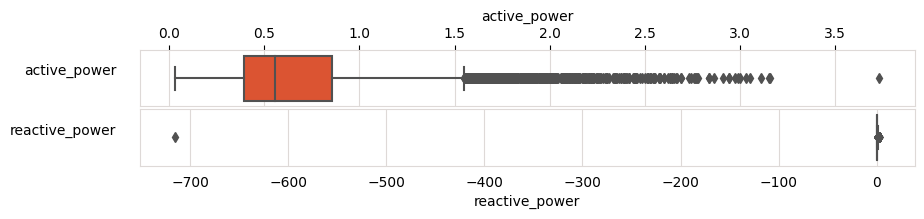

,reactive_power
9780,-715.504924
5596,0.020806
2419,0.021154
4914,0.022485
4633,0.022983


,key,begin_heat,end_heat,active_power,reactive_power,begin_heat_first,end_heat_last,heat_iter_duration,cooldown_iter_duration,iterations_amount
9778,2116,1900-01-01 00:29:52,1900-01-01 00:31:54,0.433266,0.306141,1900-01-01 00:29:52,1900-01-01 00:52:58,122,0.000000,4
9779,2116,1900-01-01 00:35:50,1900-01-01 00:38:05,0.620265,0.408352,1900-01-01 00:29:52,1900-01-01 00:52:58,135,236.000000,4
9780,2116,1900-01-01 00:44:48,1900-01-01 00:46:37,0.495782,-715.504924,1900-01-01 00:29:52,1900-01-01 00:52:58,109,403.000000,4
9781,2116,1900-01-01 00:51:51,1900-01-01 00:52:58,0.299368,0.198796,1900-01-01 00:29:52,1900-01-01 00:52:58,67,314.000000,4



Уникальных партий: 3214


In [14]:
plt_pair_boxplot(data_arc['active_power'], data_arc['reactive_power'])

data_arc_bad_key = data_arc.nsmallest(1, 'reactive_power')['key'].ravel()[0]

display(pd.DataFrame(data_arc['reactive_power'].sort_values()).head(5).style.set_caption('Минимальные значения reactive_power'))
display(data_arc[data_arc['key'] == data_arc_bad_key].style.set_caption('Партия с аномальным значением'))

print()
print(f"Уникальных партий: {data_arc['key'].nunique()}")

Аномальные значения имеет всего одна партия. Её можно не включать в рабочую выборку.

In [15]:
data_arc = data_arc[data_arc['key'] != data_arc_bad_key]

Получим новые признаки:  
- подсчитаем суммарные значения активной и
- реактивной мощности для каждой пратии
- общее время нагрева
- общее время остывания
- общее время температурной обработки
- порядковый номер итерации (начиная с 0)

In [271]:
# общая активная мощность
data_arc = data_arc.merge(
        fast_aggregation(data_arc,
                         'active_power',
                         'total_active_power',
                         'sum'),
        how='left',
        on='key'
    )

# общая реактивная мощность
data_arc = data_arc.merge(
        fast_aggregation(data_arc,
                         'reactive_power',
                         'total_reactive_power',
                         'sum'),
        how='left',
        on='key'
    )

# общее время нагрева
data_arc = data_arc.merge(
        fast_aggregation(data_arc, 'heat_iter_duration',
                         'heat_overall_duration', 'sum'),
        on='key',
        how='left'
    )

# общее время остывания
data_arc = data_arc.merge(
        fast_aggregation(data_arc, 'cooldown_iter_duration',
                         'cooldown_overall_duration', 'sum'),
        on='key',
        how='left'
    )

# время обработки
data_arc['treatment_duration'] = data_arc['cooldown_overall_duration'] + data_arc['heat_overall_duration']

# порядковый номер
data_arc = (
        data_arc
            .join(data_arc.groupby('key')
                  .agg({'begin_heat': 'cumcount'})
                  .rename(columns={'begin_heat': 'iteration_number'}))
    )

display(data_arc[['key', 'total_active_power', 'total_reactive_power',
                  'heat_overall_duration', 'cooldown_overall_duration', 'treatment_duration', 'iteration_number']].sample(5))

,key,total_active_power,total_reactive_power,heat_overall_duration,cooldown_overall_duration,treatment_duration,iteration_number
9758,2110,1.921434,1.294955,547,5492.0,6039.0,1
5782,1257,3.290322,3.918495,907,1507.0,2414.0,4
1676,361,3.608126,2.600810,982,1478.0,2460.0,0
9170,1990,2.536037,1.619240,757,1240.0,1997.0,1
12671,2755,3.715354,3.530501,1013,690.0,1703.0,0


Также получим новый признак:
- полная мощность

Полная мощность вычисляется как геометрическая сумма активной и реактивной мощности: $S = \sqrt{P^2 + Q^2}$

In [17]:
# data_arc['power_rate'] = data_arc['reactive_power'] / data_arc['active_power']
data_arc['power_rate'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

display(data_arc[['key', 'power_rate']].sample(5))

Получим новые признаки:  
- минимальная полная мощность обработки
- максимальная полная мощность обработки
- средняя полная мощность обработки
- итерация на которой зафиксировано минимальное значение мощности
- итерация на которой зафиксировано максимальное значение мощности
- порядковый номер итерации (начиная с 0)

In [18]:
data_arc = data_arc.merge(
        data_arc
            .groupby('key', as_index=False)
            .agg({'power_rate': 'min'})
            .rename(columns={'power_rate': 'power_rate_min'}),
        on='key',
        how='left'
    )

data_arc = data_arc.merge(
        data_arc
            .groupby('key', as_index=False)
            .agg({'power_rate': 'max'})
            .rename(columns={'power_rate': 'power_rate_max'}),
        on='key',
        how='left'
    )

data_arc = data_arc.merge(
        data_arc
            .groupby('key', as_index=False)
            .agg({'power_rate': 'mean'})
            .rename(columns={'power_rate': 'power_rate_avg'}),
        on='key',
        how='left'
    )

data_arc.loc[
        data_arc['power_rate_min'] == data_arc['power_rate'],
        'min_power_rate_iteration'
    ] = data_arc['iteration_number']

data_arc.loc[
        data_arc['power_rate_max'] == data_arc['power_rate'],
        'max_power_rate_iteration'
    ] = data_arc['iteration_number']

data_arc = data_arc.merge(
        data_arc
            .groupby('key', as_index=False)
            .agg({'min_power_rate_iteration': 'sum'})
            .rename(columns={'min_power_rate_iteration': 'min_best_iteration'}),
        on='key',
        how='left'
    )

data_arc = data_arc.merge(
        data_arc
            .groupby('key', as_index=False)
            .agg({'max_power_rate_iteration': 'sum'})
            .rename(columns={'max_power_rate_iteration': 'max_best_iteration'}),
        on='key',
        how='left'
    )

display(data_arc[['key', 'power_rate_min', 'power_rate_max',
                  'power_rate_avg', 'min_best_iteration', 'max_best_iteration']].sample(5))

Результат преобразований:

In [19]:
display(data_arc.head(3))
print(data_arc.shape)

,key,begin_heat,end_heat,active_power,reactive_power,begin_heat_first,end_heat_last,heat_iter_duration,cooldown_iter_duration,iterations_amount,total_active_power,total_reactive_power,heat_overall_duration,cooldown_overall_duration,treatment_duration,iteration_number,power_rate,power_rate_min,power_rate_max,power_rate_avg,min_power_rate_iteration,max_power_rate_iteration,min_best_iteration,max_best_iteration
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,1900-01-01 11:02:14,1900-01-01 11:28:37,228,0.0,5,4.878147,3.183241,1098,485.0,1583.0,0,1.193639,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,1900-01-01 11:02:14,1900-01-01 11:28:37,185,86.0,5,4.878147,3.183241,1098,485.0,1583.0,1,0.959010,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,1900-01-01 11:02:14,1900-01-01 11:28:37,172,71.0,5,4.878147,3.183241,1098,485.0,1583.0,2,0.896038,0.807239,1.97047,1.165279,NaN,NaN,4.0,3.0


(14872, 24)


Ознакомимся с данными о мощности:

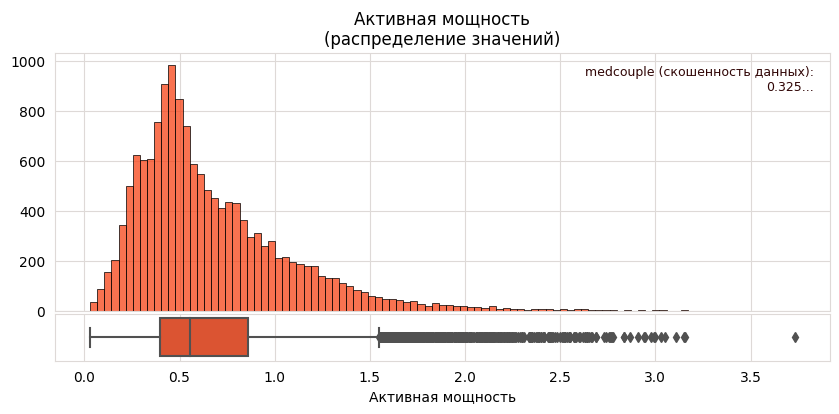

In [20]:
plt_single_distrib(data_arc['active_power'], 'Активная мощность')

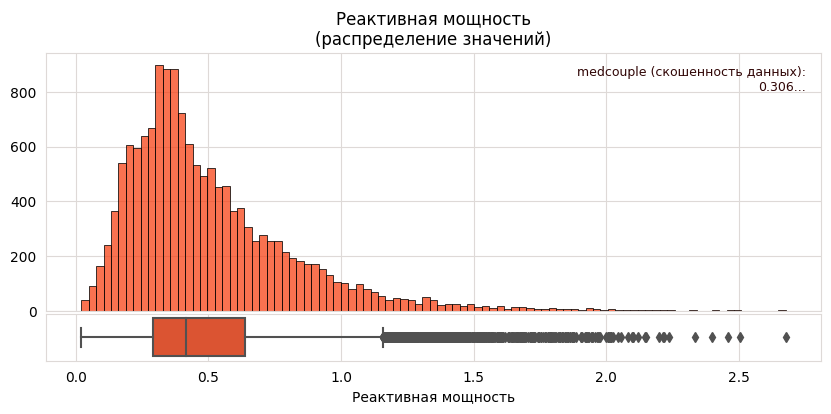

In [21]:
plt_single_distrib(data_arc['reactive_power'], 'Реактивная мощность')

Распределение данных имеет скошенность вправо, выбросы есть, но их велечина не настолько значительна чтобы принять решение об удалении прямо сейчас.

Посмотрим как взаимосвязана суммарная активная и реактивная мощность.

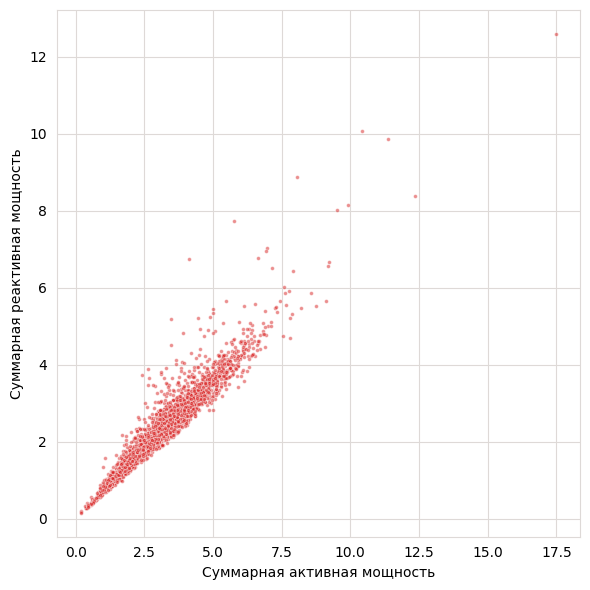

In [22]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=data_arc.drop_duplicates('key')['total_active_power'],
              y=data_arc.drop_duplicates('key')['total_reactive_power'],
              s=30, color=COLORSET[1], marker=".", alpha=.5)

plt.xlabel('Суммарная активная мощность')
plt.ylabel('Суммарная реактивная мощность')

plt.tight_layout()
plt.show()
plt.close()

Между признаками наблюдается линейная зависимость. Выбросы есть.

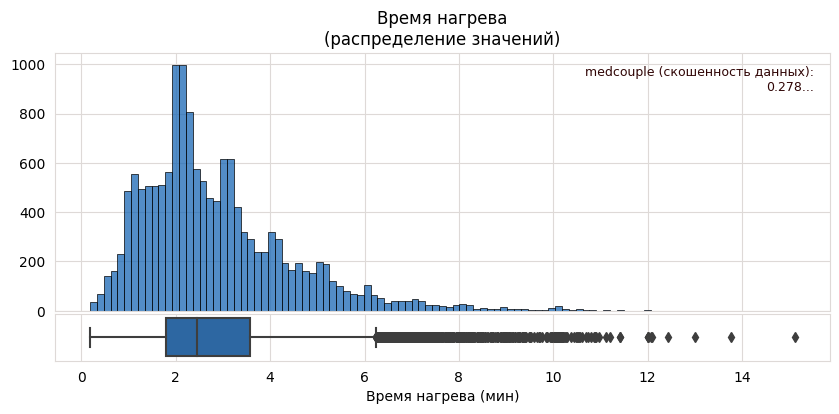

In [23]:
plt_single_distrib(data_arc['heat_iter_duration'] / 60, 'Время нагрева (мин)', COLORSET[2])

В среднем на одну итерацию включения электродов приходится 2-4 минуты.  

Проверим суммарное время нагрева.

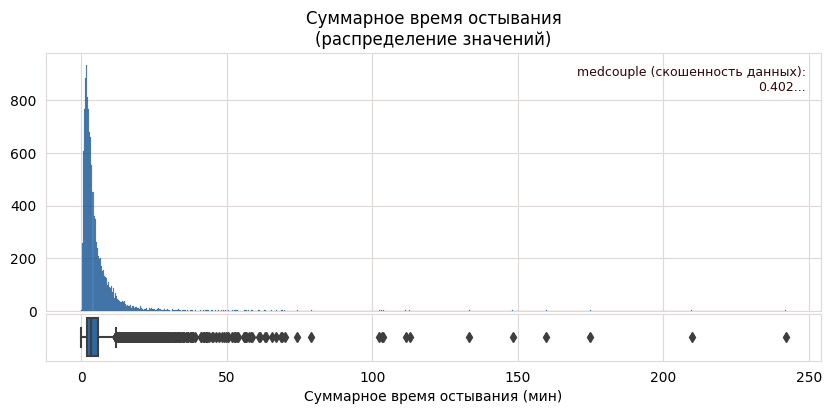

In [24]:
plt_single_distrib(data_arc[data_arc['cooldown_iter_duration'] != 0]['cooldown_iter_duration'] / 60,
                   'Суммарное время остывания (мин)', COLORSET[2])

Здесь присутствуют значительные выбросы (вероятно, из-за долгого времени остывания для некоторых партий).

In [25]:
display(
    data_arc[data_arc['key'] == data_arc[data_arc['cooldown_iter_duration'] > (60 * 200)]['key']
             .ravel()[0]][['key', 'begin_heat', 'end_heat', 'cooldown_iter_duration']]
       )

,key,begin_heat,end_heat,cooldown_iter_duration
2944,641,1900-01-01 20:31:15,1900-01-01 20:34:00,0.0
2945,641,1900-01-01 20:40:09,1900-01-01 20:44:26,369.0
2946,641,1900-01-02 00:46:34,1900-01-02 00:49:23,14528.0
2947,641,1900-01-02 00:50:16,1900-01-02 01:00:13,53.0
2948,641,1900-01-02 01:02:16,1900-01-02 01:04:53,123.0
2949,641,1900-01-02 01:15:41,1900-01-02 01:16:49,648.0


Так для одной из партий время "простоя" между нагревами составило около 4 часов. Это не выглядит как ошибка обработки временных меток, так как они расположены последовательно. Возможно, это ошибка сбора данных со стороны заказчика, однако это также возможно имело место в действительности в рамках технологического процесса.

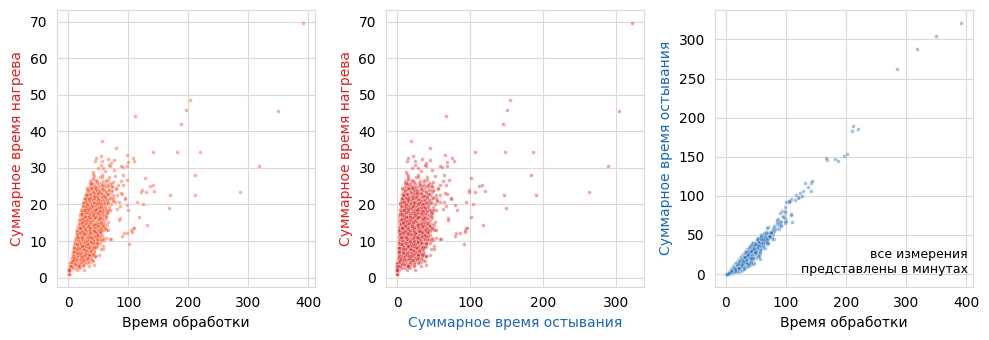

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5))

sns.scatterplot(y=data_arc.drop_duplicates('key')['heat_overall_duration'] / 60,
              x=data_arc.drop_duplicates('key')['treatment_duration'] / 60,
              s=30, color=COLORSET[0], marker=".", alpha=.4, ax=ax[0])

sns.scatterplot(x=data_arc.drop_duplicates('key')['cooldown_overall_duration'] / 60,
              y=data_arc.drop_duplicates('key')['heat_overall_duration'] / 60,
              s=30, color=COLORSET[1], marker=".", alpha=.4, ax=ax[1])

sns.scatterplot(y=data_arc.drop_duplicates('key')['cooldown_overall_duration'] / 60,
              x=data_arc.drop_duplicates('key')['treatment_duration'] / 60,
              s=30, color=COLORSET[2], marker=".", alpha=.4, ax=ax[2])

plt.ylabel('Суммарное время остывания', color=COLORSET[2])
plt.xlabel('Время обработки')
plt.text(x=0.98, y=.05, ha='right', size=9, s='все измерения\nпредставлены в минутах', transform=ax[2].transAxes)

plt.sca(ax[1])
plt.xlabel('Суммарное время остывания', color=COLORSET[2])
plt.ylabel('Суммарное время нагрева', color=COLORSET[1])

plt.sca(ax[0])
plt.ylabel('Суммарное время нагрева', color=COLORSET[1])
plt.xlabel('Время обработки')

plt.tight_layout()
plt.show()
plt.close()

Данный график подтверждает, что суммарное время обработки в большей степени зависит от времени остывания ( зависимость строго линейная), а также что перерывы между включениями электродов значительно больше, чем само время нагрева.   

Посмотрим сколько всего итераций нагрева происходит.

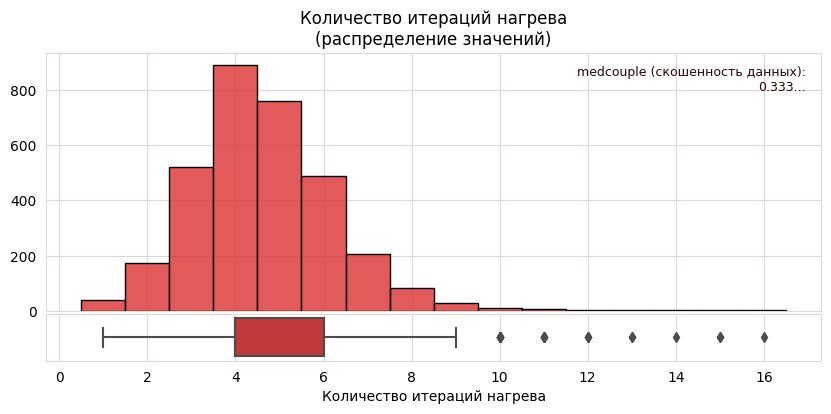

In [27]:
plt_single_distrib(data_arc.drop_duplicates('key')['iterations_amount'], 'Количество итераций нагрева', COLORSET[1])

В среднем за обработку происходит от 4 до 6 итераций нагрева. Редко - до 16.   


Проведен анализ данных о работе элементов нагрева.   
 
- сгенерированы дополнительные признаки
- распределение значений близко к нормальному, однако есть выбросы справа
- активная и реактивная мощность линейно зависимы
- на общее врем обработки значительно влияет время остывания сплава между итерациями нагрева  


- [К оглавлению](#0)  

#### Сыпучие материалы (гранулированный сплав)<a id="22"></a>

In [ ]:
hide_code()

In [263]:
report_initial(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46935 entries, 0 to 46934
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  46935 non-null  int64  
 1   bulk_number          46935 non-null  int64  
 2   bulk_amount          46935 non-null  float64
 3   overall_bulk_amount  46935 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.4 MB
None


,key,bulk_number,bulk_amount,overall_bulk_amount
0,1,1,0.0,553.0
1,1,2,0.0,553.0
2,1,3,0.0,553.0
3,1,4,43.0,553.0
4,1,5,0.0,553.0


(46935, 4)
Дубликатов: 0


Согласно информации заказчика, пропущенные значения означают, что материал на этих итерациях не добавлялся.     

Пустые значения заменим нулями (добавлен нулевой объем материала), и соберем данные об объемах в одной колонке.

In [29]:
data_bulk_initial = data_bulk.copy(deep=True)
data_bulk = data_bulk.melt(id_vars='key', value_vars=data_bulk.drop('key', axis=1).columns, value_name='bulk_amount')
data_bulk['variable'] = data_bulk['variable'].apply(lambda x: int(x.split(' ')[1]))
data_bulk = data_bulk.sort_values(['key', 'variable'])
data_bulk = data_bulk.rename(columns={'variable': 'bulk_number'})
data_bulk = data_bulk.fillna(0)

data_bulk = data_bulk.merge(
                data_bulk.groupby('key', as_index=False, dropna=False)
                    .agg({'bulk_amount': 'sum'})
                    .rename(columns={'bulk_amount': 'overall_bulk_amount'}),
                on='key', how='left'
            )

display(data_bulk.head())
print(data_bulk.shape)

,key,bulk_number,bulk_amount,overall_bulk_amount
0,1,1,0.0,553.0
1,1,2,0.0,553.0
2,1,3,0.0,553.0
3,1,4,43.0,553.0
4,1,5,0.0,553.0


(46935, 4)


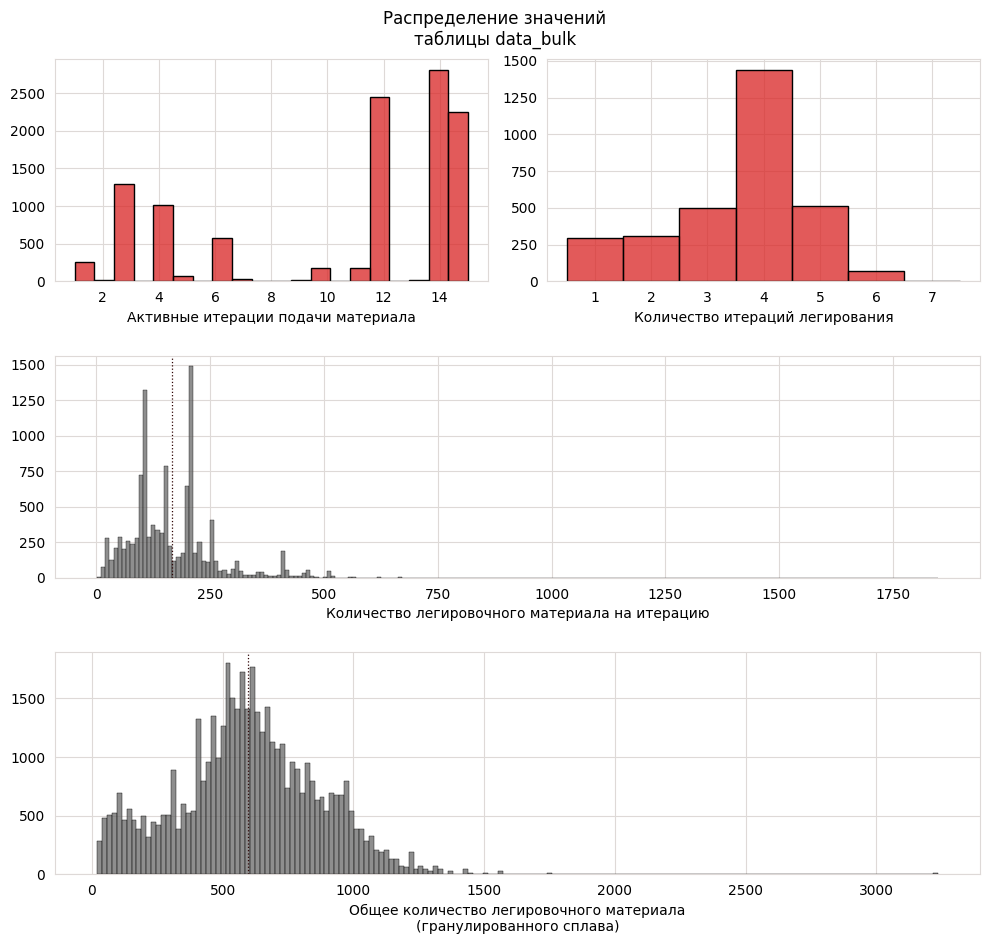

In [30]:
fig = plt.figure(figsize=(10, 12))

ax1=plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2=plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3=plt.subplot2grid((4, 2), (1, 0), colspan=2)
ax4=plt.subplot2grid((4, 2), (2, 0), colspan=2)

sns.histplot(x=data_bulk[data_bulk['bulk_amount'] > 0]['bulk_number'].astype(int),
                 color=COLORSET[1],
                 ax=ax1)

sns.histplot(x=data_bulk[data_bulk['bulk_amount'] > 0]
                     .groupby('key', as_index=False, dropna=False)
                     .agg({'bulk_number': 'count'})['bulk_number'],
                 color=COLORSET[1],
                 discrete=True,
                 ax=ax2)

sns.histplot(x=data_bulk['overall_bulk_amount'].astype(int),
                 color='dimgray',
                 ax=ax4)

sns.histplot(x=data_bulk[data_bulk['bulk_amount'] > 0]['bulk_amount'].astype(int),
                 color='dimgray',
                 ax=ax3)


plt.sca(ax3)
plt.xlabel('Количество легировочного материала на итерацию')
plt.ylabel('')
plt.axvline(data_bulk[data_bulk['bulk_amount'] > 0]['bulk_amount'].mean(), ls=':', lw=.9, color=COLORSET[4])

plt.sca(ax4)
plt.xlabel('Общее количество легировочного материала\n(гранулированного сплава)')
plt.ylabel('')
plt.axvline(data_bulk['overall_bulk_amount'].astype(int).mean(), ls=':', lw=.9, color=COLORSET[4])

plt.sca(ax1)
plt.xlabel('Активные итерации подачи материала')
plt.ylabel('')

plt.sca(ax2)
plt.xlabel('Количество итераций легирования')
plt.ylabel('')

plt.suptitle('Распределение значений\nтаблицы data_bulk')
plt.tight_layout()
plt.show()
plt.close()

- Чаще всего легировочный материал добавляется на 12 и 14 итерациях. 
- Чаще всего материал добавляется 4 раза за время обработки партии.
- Признак количества единоразово добавляемого материала имеет значительные выбросы
- Признак общего количества добавляемого материала также имеет выбросы
- в среднем объем добавляемого материала равен ~600

#### Сыпучие материалы - время добавления<a id="23"></a>

In [31]:
display(data_bulk_time.head())
print(data_bulk_time.shape)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


(3129, 16)


Можно заметить несоответствие временных меток очереди добавления. Кроме того, временные метки для разных итераций в некоторых случаях одинаковые.    

Приведем эти значения к адекватным величинам.

In [32]:
data_bulk_time_initial = data_bulk_time.copy(deep=True)
data_bulk_time = data_bulk_time.melt(id_vars='key',
                                     value_vars=data_bulk_time.drop('key', axis=1).columns,
                                     value_name='bulk_time')

data_bulk_time['variable'] = data_bulk_time['variable'].apply(lambda x: int(x.split(' ')[1]))

data_bulk_time = data_bulk_time.sort_values(['key', 'variable'])
data_bulk_time = data_bulk_time.rename(columns={'variable': 'bulk_number'})

data_bulk_time['bulk_time'] = pd.to_datetime(data_bulk_time['bulk_time'], format='%H:%M:%S')

In [33]:
data_bulk_time = data_bulk_time.merge(
        data_bulk_time.groupby('key', as_index=False, dropna=False)
            .agg({'bulk_time': 'min'})
            .rename(columns={'bulk_time': 'min_bulk_time'}),
        on='key', how='left'
    )

data_bulk_time = data_bulk_time.merge(
        data_bulk_time.groupby('key', as_index=False, dropna=False)
            .agg({'bulk_time': 'max'})
            .rename(columns={'bulk_time': 'max_bulk_time'}),
        on='key', how='left'
    )

min_bulk_corrected = data_bulk_time[
        (data_bulk_time['max_bulk_time'] > '1900-01-01 20:00:00') &
        (data_bulk_time['min_bulk_time'] < '1900-01-01 05:00:00')
    ]['max_bulk_time']

max_bulk_corrected = data_bulk_time[
        (data_bulk_time['max_bulk_time'] > '1900-01-01 20:00:00') &
        (data_bulk_time['min_bulk_time'] < '1900-01-01 05:00:00')
    ]['min_bulk_time']

data_bulk_time.loc[min_bulk_corrected.index, 'min_bulk_time'] = min_bulk_corrected
data_bulk_time.loc[max_bulk_corrected.index, 'max_bulk_time'] = max_bulk_corrected

In [34]:
data_bulk_time['bulk_duration'] = data_bulk_time['max_bulk_time'] - data_bulk_time['min_bulk_time']
data_bulk_time['bulk_duration'] = data_bulk_time['bulk_duration'].dt.seconds

display(data_bulk_time.head(3))
print(data_bulk_time.shape)

,key,bulk_number,bulk_time,min_bulk_time,max_bulk_time,bulk_duration
0,1,1,NaT,1900-01-01 11:03:52,1900-01-01 11:21:30,1058
1,1,2,NaT,1900-01-01 11:03:52,1900-01-01 11:21:30,1058
2,1,3,NaT,1900-01-01 11:03:52,1900-01-01 11:21:30,1058


(46935, 6)


Единственный признак, который можно выделить из данной таблицы - время между итерациями добавления сыпучих материалов, однако, используя его в дальнейшем следует учитывать проблемность изнаальных данных.

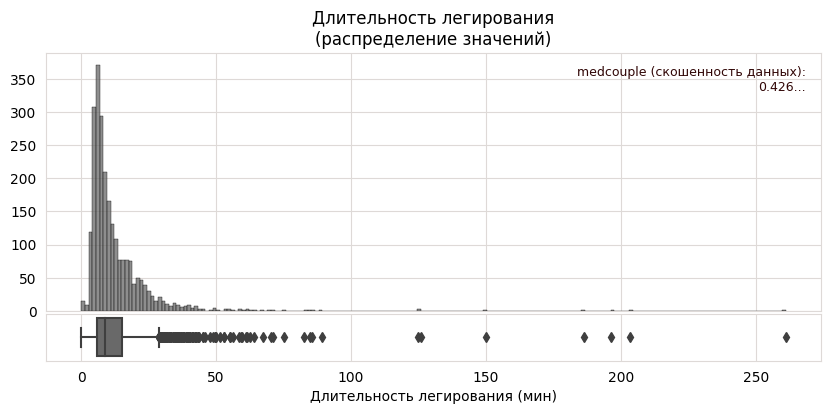

In [35]:
plt_single_distrib(
        data_bulk_time[data_bulk_time['bulk_duration'] > 0]
            .drop_duplicates('key')['bulk_duration'] / 60,
        'Длительность легирования (мин)', 'dimgray'
    )

- В данных о времени между сесиями добавления гранулированного сплава есть выбросы.

#### Порошковая проволока<a id="24"></a>

In [275]:
hide_code()

In [264]:
report_initial(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27729 entries, 0 to 27728
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  27729 non-null  int64  
 1   wire_number          27729 non-null  int64  
 2   wire_amount          27729 non-null  float64
 3   overall_wire_amount  27729 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 866.7 KB
None


,key,wire_number,wire_amount,overall_wire_amount
0,1,1,60.059998,60.059998
1,1,2,0.000000,60.059998
2,1,3,0.000000,60.059998
3,1,4,0.000000,60.059998
4,1,5,0.000000,60.059998


(27729, 4)
Дубликатов: 0


Данные о добавлении порошковой проволоки приведём к форме, аналогичной данным о гранулированном сплаве.

In [37]:
data_wire_initial = data_wire.copy(deep=True)
data_wire = data_wire.melt(id_vars='key', value_vars=data_wire.drop('key', axis=1).columns, value_name='wire_amount')
data_wire['variable'] = data_wire['variable'].apply(lambda x: int(x.split(' ')[1]))
data_wire = data_wire.sort_values(['key', 'variable'])
data_wire = data_wire.rename(columns={'variable': 'wire_number'})
data_wire = data_wire.fillna(0)

data_wire = data_wire.merge(
                data_wire.groupby('key', as_index=False, dropna=False)
                    .agg({'wire_amount': 'sum'})
                    .rename(columns={'wire_amount': 'overall_wire_amount'}),
                on='key', how='left'
            )

display(data_wire.head())
print(data_wire.shape)

,key,wire_number,wire_amount,overall_wire_amount
0,1,1,60.059998,60.059998
1,1,2,0.000000,60.059998
2,1,3,0.000000,60.059998
3,1,4,0.000000,60.059998
4,1,5,0.000000,60.059998


(27729, 4)


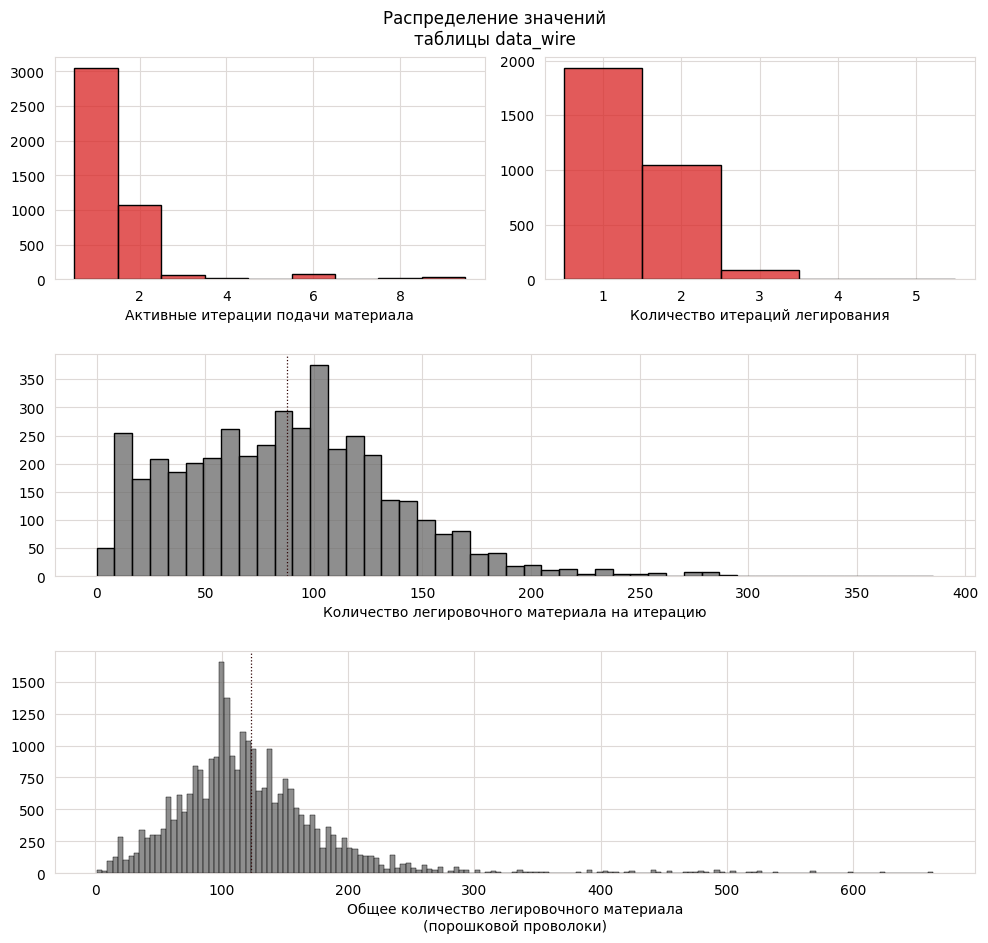

In [38]:
fig = plt.figure(figsize=(10, 12))

ax1=plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2=plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3=plt.subplot2grid((4, 2), (1, 0), colspan=2)
ax4=plt.subplot2grid((4, 2), (2, 0), colspan=2)

sns.histplot(x=data_wire[data_wire['wire_amount'] > 0]['wire_number'].astype(int),
                 color=COLORSET[1], discrete=True,
                 ax=ax1)

sns.histplot(x=data_wire[data_wire['wire_amount'] > 0]
                     .groupby('key', as_index=False, dropna=False)
                     .agg({'wire_number': 'count'})['wire_number'],
                 color=COLORSET[1],
                 discrete=True,
                 ax=ax2)

sns.histplot(x=data_wire['overall_wire_amount'].astype(int),
                 color='dimgray',
                 ax=ax4)

sns.histplot(x=data_wire[data_wire['wire_amount'] > 0]['wire_amount'].astype(int),
                 color='dimgray',
                 ax=ax3)


plt.sca(ax3)
plt.xlabel('Количество легировочного материала на итерацию')
plt.ylabel('')
plt.axvline(x=data_wire[data_wire['wire_amount'] > 0]['wire_amount'].astype(int).mean(), ls=':', lw=.9, color=COLORSET[4])

plt.sca(ax4)
plt.xlabel('Общее количество легировочного материала\n(порошковой проволоки)')
plt.ylabel('')
plt.axvline(x=data_wire['overall_wire_amount'].astype(int).mean(), ls=':', lw=.9, color=COLORSET[4])

plt.sca(ax1)
plt.xlabel('Активные итерации подачи материала')
plt.ylabel('')

plt.sca(ax2)
plt.xlabel('Количество итераций легирования')
plt.ylabel('')

plt.suptitle('Распределение значений\nтаблицы data_wire')
plt.tight_layout()
plt.show()
plt.close()

- Вак правило итераций добавления проволоки не более двух
- В среднем объем порошковой проволоки, подаваемой за время обработки равен ~120
- В данных об общем количестве поданной в сплав проволоки есть выбросы

#### Порошковая проволока - время добавления<a id="25"></a>
Здесь будут проведены преобразования, связанные со стандартизацией временных меток, аналогичные таблице о времени добавления гранцлированного сплава.

In [39]:
data_wire_time_initial = data_wire_time.copy(deep=True)
data_wire_time = data_wire_time.melt(id_vars='key',
                                     value_vars=data_wire_time.drop('key', axis=1).columns,
                                     value_name='wire_time')

data_wire_time['variable'] = data_wire_time['variable'].apply(lambda x: int(x.split(' ')[1]))

data_wire_time = data_wire_time.sort_values(['key', 'variable'])
data_wire_time = data_wire_time.rename(columns={'variable': 'wire_number'})

data_wire_time['wire_time'] = pd.to_datetime(data_wire_time['wire_time'], format='%H:%M:%S')

In [40]:
data_wire_time = data_wire_time.merge(
        data_wire_time.groupby('key', as_index=False, dropna=False)
            .agg({'wire_time': 'min'})
            .rename(columns={'wire_time': 'min_wire_time'}),
        on='key', how='left'
    )

data_wire_time = data_wire_time.merge(
        data_wire_time.groupby('key', as_index=False, dropna=False)
            .agg({'wire_time': 'max'})
            .rename(columns={'wire_time': 'max_wire_time'}),
        on='key', how='left'
    )

min_wire_corrected = data_wire_time[
        (data_wire_time['max_wire_time'] > '1900-01-01 20:00:00') &
        (data_wire_time['min_wire_time'] < '1900-01-01 05:00:00')
    ]['max_wire_time']

max_wire_corrected = data_wire_time[
        (data_wire_time['max_wire_time'] > '1900-01-01 20:00:00') &
        (data_wire_time['min_wire_time'] < '1900-01-01 05:00:00')
    ]['min_wire_time']

data_wire_time.loc[min_wire_corrected.index, 'min_wire_time'] = min_wire_corrected
data_wire_time.loc[max_wire_corrected.index, 'max_wire_time'] = max_wire_corrected

In [41]:
data_wire_time['wire_duration'] = data_wire_time['max_wire_time'] - data_wire_time['min_wire_time']
data_wire_time['wire_duration'] = data_wire_time['wire_duration'].dt.seconds

display(data_wire_time.head(3))
print(data_wire_time.shape)

,key,wire_number,wire_time,min_wire_time,max_wire_time,wire_duration
0,1,1,1900-01-01 11:11:41,1900-01-01 11:11:41,1900-01-01 11:11:41,0
1,1,2,NaT,1900-01-01 11:11:41,1900-01-01 11:11:41,0
2,1,3,NaT,1900-01-01 11:11:41,1900-01-01 11:11:41,0


(27729, 6)


  


- [К оглавлению](#0)  

#### Продувочный газ<a id="26"></a>

In [42]:
report_initial(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


(3239, 2)


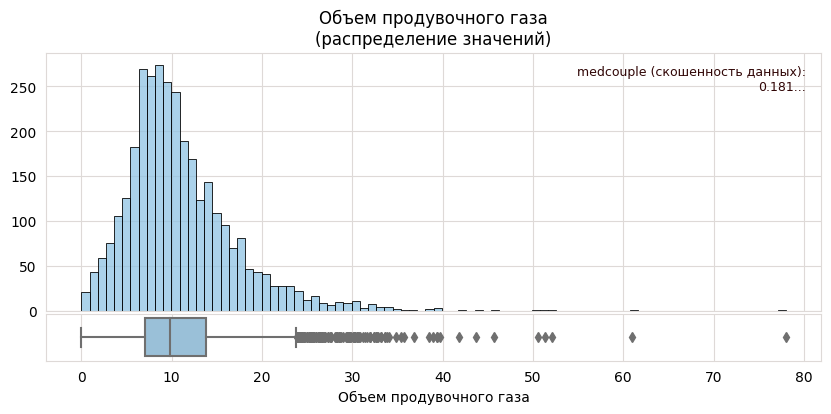

In [43]:
plt_single_distrib(data_gas['gas'], 'Объем продувочного газа', COLORSET[3])

- Данные не нуждаются в предобработке
- Есть выбросы

#### Температура плавки<a id="27"></a>

In [ ]:
hide_code()

In [265]:
report_initial(data_temp)

<class 'pandas.core.frame.DataFrame'>
Index: 2471 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2471 non-null   int64  
 1   initial_temperature  2471 non-null   float64
 2   target_temperature   2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB
None


,key,initial_temperature,target_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


(2471, 3)
Дубликатов: 0


Данные о замерах температуры также имеют временные метки без указания даты. По аналогии с предыдущими таблицами, проведем преобразования, которые позволят выделить первую и последнюю метку замера температуры.

In [45]:
data_temp.columns = column_names_lower(data_temp)
data_temp['mesaure_time'] = pd.to_datetime(data_temp['mesaure_time'], format='%H:%M:%S')
data_temp_checkpoint = data_temp.copy(deep=True)

# получение первого замера
data_temp = data_temp.merge(
        data_temp.groupby('key', as_index=False, dropna=False)
            .agg({'mesaure_time': 'first'})
            .rename(columns={'mesaure_time': 'first_mesaure_time'}),
        on='key',
        how='left'
    )

# прибавление 1 дня если следующий замер меньше первого
data_temp.loc[
        (data_temp['first_mesaure_time'] > data_temp['mesaure_time']),
        'mesaure_time'
    ] += pd.DateOffset(days=1)

data_temp = data_temp.sort_values(['key', 'mesaure_time'])

In [47]:
def temp_measures_check(id_number):
    '''
    Функция для сопоставления времени замеров и нагрева.
    Не предназначена для изменения данных - только визуальное представление.
    '''

    time_data = pd.concat(
        [
            data_arc[data_arc['key'] == id_number]
                        [['key', 'begin_heat', 'end_heat']]
                .rename(columns={'begin_heat': 'начало нагрева или замер t',
                                 'end_heat': 'конец нагрева',
                                 'key': 'id партии'}),
            
               data_temp_checkpoint[data_temp_checkpoint['key'] == id_number]
                        [['key', 'mesaure_time', 'temperature']]
            .rename(columns={'temperature': 'температура',
                             'key': 'id партии',
                             'mesaure_time': 'начало нагрева или замер t'})
        ], axis=0
    ).sort_values('начало нагрева или замер t')

    time_data['начало нагрева или замер t'] = time_data['начало нагрева или замер t'].dt.time
    time_data['конец нагрева'] = time_data['конец нагрева'].dt.time

    display(time_data)

По уловиям, нельзя брать партии где есть только одно наблюдение. Поэтому отсеми такие записи, предварительно посмотрев пару примеров.

In [49]:
data_temp_index_1 = data_temp.groupby('key', as_index=False).agg({'temperature': 'count'}).query('temperature == 1')

temp_measures_check(data_temp_index_1.sample(random_state=1)['key'].ravel()[0])
temp_measures_check(data_temp_index_1.sample(random_state=2)['key'].ravel()[0])

,id партии,начало нагрева или замер t,конец нагрева,температура
12758,2772,01:43:32,01:45:29,NaN
13631,2772,01:46:46,NaT,1602.0
12759,2772,01:49:23,01:51:43,NaN
13632,2772,01:55:40,NaT,NaN
12760,2772,01:56:54,02:00:10,NaN
13633,2772,02:02:00,NaT,NaN


,id партии,начало нагрева или замер t,конец нагрева,температура
14763,3217,07:30:56,07:33:39,NaN
15789,3217,07:34:50,NaT,1594.0
14764,3217,07:37:14,07:40:36,NaN
14765,3217,07:42:27,07:43:39,NaN
15790,3217,07:46:10,NaT,NaN
14766,3217,07:46:30,07:51:18,NaN
15791,3217,07:52:05,NaT,NaN


В данных примерах видно, что для партий 2772 и 3217 есть только один замер - в начале обработки.   

Уберем такие партии из выборки.

In [50]:
data_temp = data_temp[~data_temp['key'].isin(data_temp_index_1['key'])]

# получение первой температуры
data_temp_first = (
    data_temp
        .groupby('key', as_index=False, dropna=False)
        .agg({'temperature': 'first'})
        .rename(columns={'temperature': 'initial_temperature'})
    )

# получение последней температуры (таргет)
data_temp_last = (
    data_temp
        .groupby('key', as_index=False, dropna=False)
        .agg({'temperature': 'last'})
        .rename(columns={'temperature': 'target_temperature'})
    )

data_temp = data_temp_first.merge(data_temp_last, on='key', how='left')

display(data_temp.head())
print(data_temp.shape)
print()
print("В результате удаления записей с единственным показателем температуры" +
      f" удалено {len(data_temp_index_1) / data_temp_checkpoint['key'].nunique():.1%} записей")

Для дальнейшего использования взяты данные только о первом замере (один из признаков модели), и о последнем замере, который имеет запись о температуре плавки.

К сожалению заказчик не уточнил, что значит "первый" и "последний" замер. Все записи имеют первый замер температуры после первой или второй итерации нагрева. Считать ли первую запись после второго нагрева дефектом, и исключать такие партии? Формально, такая запись всё ещё "первая", кроме того, отбросив такие данные можно потерять значительную часть выборки. Пример такой записи - ниже.

In [52]:
display(data_temp[data_temp['key'] == 2312])
temp_measures_check(2312)

,key,initial_temperature,target_temperature
2292,2312,1591.0,1591.0


,id партии,начало нагрева или замер t,конец нагрева,температура
10627,2312,09:45:49,09:47:50,NaN
10628,2312,09:51:37,09:55:06,NaN
11359,2312,09:56:22,NaT,1591.0
10629,2312,10:02:25,10:04:35,NaN
11360,2312,10:06:36,NaT,1591.0


Кроме того, записи о температуре в данном примере, как и в следующем, идентичны. Можно предположить, что это дефект сбора данных, однако, возможно, также, что технологический процесс предусматривает поддержание одной температуры.

In [53]:
display(data_temp[data_temp['key'] == 632])
temp_measures_check(632)

,key,initial_temperature,target_temperature
621,632,1579.0,1579.0


,id партии,начало нагрева или замер t,конец нагрева,температура
2898,632,15:59:42,16:02:44,NaN
3221,632,16:04:07,NaT,1579.0
2899,632,16:05:40,16:10:20,NaN
3222,632,16:12:34,NaT,1579.0
2900,632,16:13:07,16:14:43,NaN
3223,632,16:19:25,NaT,1579.0


Кроме того, ниже представлен пример, где промежуточные значения температуры отличаются, но первое и последнее - идентичны. 

In [54]:
display(data_temp[data_temp['key'] == 826])
temp_measures_check(826)

,key,initial_temperature,target_temperature
812,826,1598.0,1598.0


,id партии,начало нагрева или замер t,конец нагрева,температура
3828,826,00:37:40,00:40:56,NaN
4155,826,00:42:06,NaT,1598.0
3829,826,00:42:57,00:50:40,NaN
4156,826,00:53:35,NaT,1606.0
3830,826,00:54:00,00:56:27,NaN
3831,826,01:21:26,01:22:29,NaN
4157,826,01:23:11,NaT,1605.0
3832,826,01:25:04,01:26:05,NaN
4158,826,01:39:29,NaT,1595.0
3833,826,01:40:03,01:42:05,NaN


Ошибка ли это? - ответить мог бы только заказчик. В текущей ситуации будем использовать все данные о температуре, что есть в наличии (кроме промежуточных значений)

In [55]:
print(f'Записей о температуре: {len(data_temp)}')
print()
print('Количество пропусков:')
print(data_temp.isna().sum())
print()
print(f"Отсутствует {data_temp['target_temperature'].isna().sum() / len(data_temp):.2%} данных о целевых наблюдениях")

Записей о температуре: 2475

Количество пропусков:
key                    0
initial_temperature    0
target_temperature     0
dtype: int64

Отсутствует 0.00% данных о целевых наблюдениях


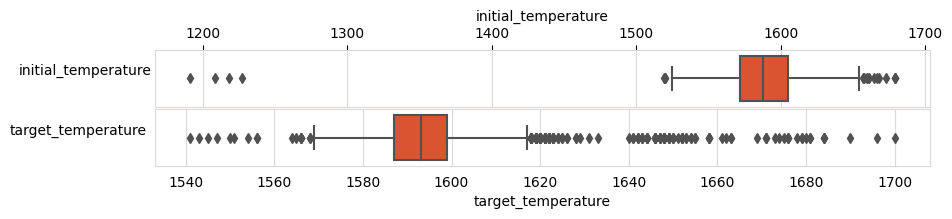

In [56]:
plt_pair_boxplot(data_temp['initial_temperature'], data_temp['target_temperature'])

Данные об исходной и целевой температуре имеют несколько записей с аномально низкой, как указано заказчиком, температурой.   
Заказчик, однако, не уточнил, что именно значит "аномальные" - в случае если таких значений быть не может, возможно имеет место быть неправильная запись, и эти значения можно было бы заменить средним.
В случае же, если "аномальные", означает, что нарушен технологический процесс - эти партии являются "бракованными" и должны быть исключены.  

In [57]:
data_temp = data_temp[data_temp['initial_temperature'] > 1500]

Также проверим нормальность распределения целевого признака, что важно для корректного получения прогноза.

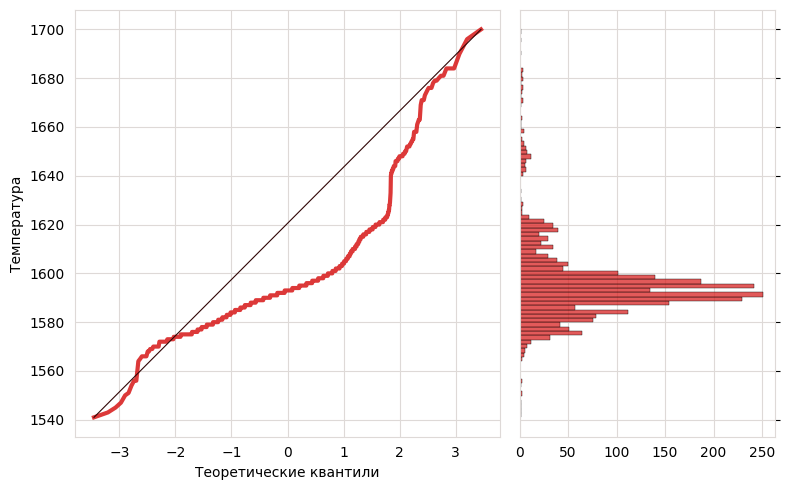

p-значение:  0.0
Распределение не отвечает критериям нормальности


In [58]:
plt_qq(data_temp[data_temp['target_temperature'].notna()]['target_temperature'])
shapiro_test(data_temp[data_temp['target_temperature'].notna()]['target_temperature'])

Распределение целевого признака не отвечает параметром нормальности. При разработки модели может быть применена нормализация целевого признака.  



Проверим как соотносится начальная и целевая температура.

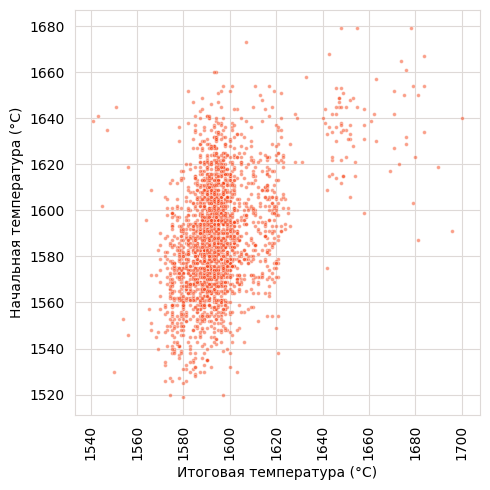

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(y=data_temp['initial_temperature'],
              x=data_temp['target_temperature'],
              s=30, color=COLORSET[0], marker=".", alpha=.5)

plt.xlabel('Итоговая температура (°C)')
plt.ylabel('Начальная температура (°C)')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
plt.close()

При низкой начальной температуре практически всегда остается низкой и итоговая. В случае с более высокой начальной температурой тенденция не столь очевидна.    


Проведено исследование значений температуры.
- Отброшены партии с аномальными значениями начальной температуры.
- Часть данных о последних измерениях температуры (целевой признак) - отсутствует.
- Распределение целевого признака не является нормальным.  


- [К оглавлению](#0)  

#### Объединение данных<a id="28"></a>
Объединим таблицы для дальнейшей работы.

In [ ]:
hide_code()

In [60]:
g_data_arc = data_arc[['key',
                       'iterations_amount',
                       'total_active_power',
                       'begin_heat_first',
                       'end_heat_last',
                       'total_reactive_power',
                       'heat_overall_duration',
                       'cooldown_overall_duration',
                       'treatment_duration',
                       'power_rate_min',
                       'power_rate_max',
                       'power_rate_avg',
                       'min_best_iteration',
                       'max_best_iteration']].groupby('key', as_index=False).mean()

g_data_bulk = data_bulk[['key',
                         'bulk_amount',
                         'overall_bulk_amount']].groupby('key', as_index=False).agg('mean')

g_data_bulk_time = data_bulk_time[['key',
                                   'min_bulk_time',
                                   'max_bulk_time',
                                   'bulk_duration']].groupby('key', as_index=False).agg('mean')

g_data_wire = data_wire[['key',
                         'wire_amount',
                         'overall_wire_amount']].groupby('key', as_index=False).agg('mean')

g_data_wire_time = data_wire_time[['key',
                                   'min_wire_time',
                                   'max_wire_time',
                                   'wire_duration']].groupby('key', as_index=False).agg('mean')

df = (
            g_data_arc
            .merge(data_temp, on='key', how='left')
            .merge(g_data_bulk, on='key', how='left')
            .merge(g_data_bulk_time, on='key', how='left')
            .merge(g_data_wire, on='key', how='left')
            .merge(g_data_wire_time, on='key', how='left')
            .merge(data_gas, on='key', how='left')
        )

display(df.head())
print(df.shape)

,key,iterations_amount,total_active_power,begin_heat_first,end_heat_last,total_reactive_power,heat_overall_duration,cooldown_overall_duration,treatment_duration,power_rate_min,power_rate_max,power_rate_avg,min_best_iteration,max_best_iteration,initial_temperature,target_temperature,bulk_amount,overall_bulk_amount,min_bulk_time,max_bulk_time,bulk_duration,wire_amount,overall_wire_amount,min_wire_time,max_wire_time,wire_duration,gas
0,1,5.0,4.878147,1900-01-01 11:02:14.000000256,1900-01-01 11:28:37,3.183241,1098.0,485.0,1583.0,0.807239,1.970470,1.165279,4.0,3.0,1571.0,1613.0,36.866667,553.0,1900-01-01 11:03:52.000000000,1900-01-01 11:21:30,1058.0,6.673333,60.059998,1900-01-01 11:11:41.000000000,1900-01-01 11:11:41,0.0,29.749986
1,2,4.0,3.052598,1900-01-01 11:34:14.000000000,1900-01-01 11:53:18,1.998112,811.0,333.0,1144.0,0.521549,1.574162,0.912304,0.0,1.0,1581.0,1602.0,38.800000,582.0,1900-01-01 11:40:20.000000256,1900-01-01 11:46:38,378.0,10.672479,96.052315,1900-01-01 11:46:10.000000000,1900-01-01 11:46:10,0.0,12.555561
2,3,5.0,2.525882,1900-01-01 12:06:54.000000256,1900-01-01 12:32:19,1.599076,655.0,870.0,1525.0,0.294865,1.256527,0.597907,4.0,0.0,1596.0,1599.0,36.266667,544.0,1900-01-01 12:09:40.000000256,1900-01-01 12:31:06,1286.0,10.128906,91.160157,1900-01-01 12:13:47.000000000,1900-01-01 12:13:47,0.0,28.554793
3,4,4.0,3.209250,1900-01-01 12:39:37.000000000,1900-01-01 12:57:50,2.060298,741.0,352.0,1093.0,0.503286,1.435385,0.953741,1.0,3.0,1601.0,1625.0,39.666667,595.0,1900-01-01 12:41:24.000000256,1900-01-01 12:48:43,439.0,9.895946,89.063515,1900-01-01 12:48:05.000000000,1900-01-01 12:48:05,0.0,18.841219
4,5,4.0,3.347173,1900-01-01 13:11:13.000000000,1900-01-01 13:33:55,2.252643,869.0,493.0,1362.0,0.323503,1.930707,1.008939,3.0,2.0,1576.0,1602.0,38.933333,584.0,1900-01-01 13:12:56.000000000,1900-01-01 13:18:50,354.0,10.928088,98.352796,1900-01-01 13:18:14.999999744,1900-01-01 13:32:06,831.0,5.413692


(3213, 27)


Каждой партии соответствует одно наблюдение.   

Проведем дополнительный анализ, чтобы выяснить какое время является полным временем обработки.

In [61]:
df['first_heat_last_bulk_delta'] = df['max_bulk_time'] - df['begin_heat_first']
df['first_heat_last_wire_delta'] = df['max_wire_time'] - df['begin_heat_first']

fix, ax = plt.subplots(figsize=(10, 4))
plt.grid(False)

sns.kdeplot(df['first_heat_last_bulk_delta'].dt.seconds, label='начало нагрева : конец легирования (сплав)', color='#a3d5d9')
sns.kdeplot(df['first_heat_last_wire_delta'].dt.seconds, label='начало нагрева : конец легирования (провод)', color='#6099a8')
sns.kdeplot(df['heat_overall_duration'], label='время нагрева', color=COLORSET[1])
sns.kdeplot(df['treatment_duration'], label='полный цикл (включая охлаждение)', color=COLORSET[0])


plt.axvline(df['first_heat_last_bulk_delta'].dt.seconds.mean(), ls=':', lw=1, color='#a3d5d9')
plt.axvline(df['first_heat_last_wire_delta'].dt.seconds.mean(), ls=':', lw=1, color='#6099a8')
plt.axvline(df['heat_overall_duration'].mean(), ls=':', lw=1, color=COLORSET[1])
plt.axvline(df['treatment_duration'].mean(), ls=':', lw=1, color=COLORSET[0])

plt.ylabel('')
plt.xlabel('Время (сек)')
plt.legend()
plt.xlim([0, 5000])
plt.show()
plt.close()

Судя по тому, что среднее значение общего времени обработки наибольшее - это и есть максимальное, то есть действительно "общее" время обработки сплава.    

Удалим ненужные столбцы, и проверим где ещё остались пропущенные значения.

In [64]:
df = df.drop(['begin_heat_first',
              'end_heat_last',
              'min_bulk_time',
              'max_bulk_time',
              'min_wire_time',
              'max_wire_time',
              'first_heat_last_bulk_delta',
              'first_heat_last_wire_delta'], axis=1)

df.columns = [ 'id', 'heat_iterations_amount', 'active_power', 'reactive_power',
               'heat_duration', 'cooldown_duration',
               'treatment_duration', 'min_power_rate','max_power_rate', 'power_rate',
               'min_power_rate_iter', 'max_power_rate_iter',
               'initial_temperature', 'target_temperature',
               'mean_bulk_amount', 'total_bulk_amount', 'bulking_timedelta',
               'mean_wire_amount', 'total_wire_amount', 'wiring_timedelta',
               'gas_volume']


df = df[[   'id', 'initial_temperature', 'gas_volume',
            'heat_iterations_amount', 'active_power', 'reactive_power',
            'power_rate', 'min_power_rate','max_power_rate',
            'min_power_rate_iter', 'max_power_rate_iter',
            'heat_duration', 'cooldown_duration', 'treatment_duration',
            'mean_bulk_amount', 'total_bulk_amount', 'bulking_timedelta',
            'mean_wire_amount', 'total_wire_amount',
            'wiring_timedelta','target_temperature' 
            ]]

df['min_power_rate_iter'] = df['min_power_rate_iter'].astype('category')
df['max_power_rate_iter'] = df['max_power_rate_iter'].astype('category')

print(df.isna().sum())

id                          0
initial_temperature       743
gas_volume                  2
heat_iterations_amount      0
active_power                0
reactive_power              0
power_rate                  0
min_power_rate              0
max_power_rate              0
min_power_rate_iter         0
max_power_rate_iter         0
heat_duration               0
cooldown_duration           0
treatment_duration          0
mean_bulk_amount           86
total_bulk_amount          86
bulking_timedelta          86
mean_wire_amount          134
total_wire_amount         134
wiring_timedelta          134
target_temperature        743
dtype: int64


743 пропущенных значения, связанных с температурой, это данные о замерах в партиях, где был всего один замер. Для верности можно сопоставить это число с длинной списка таких "бракованных" замеров. 

In [65]:
len(data_temp_index_1)

741

Эти записи придется удалить, так как без целевого признака они бесполезны.

Пропущенные значения в колонках, соответствующих процессам легирования, означают что добавление гранулированного сплава или порошковой проволоки не применялось. Эти значения заполним 0.   

Оставшиеся недостающие значения заполним нормальным распределением и средним.

In [66]:
df = df.dropna(subset=['initial_temperature', 'target_temperature'])

for col in ['mean_bulk_amount', 'total_bulk_amount',
            'bulking_timedelta','mean_wire_amount',
            'total_wire_amount', 'wiring_timedelta']:
    
    df[col] = df[col].fillna(0)

np.random.seed(RANDOM_STATE)
for i in df[df['initial_temperature'].isna()].index:
    df.loc[i, 'initial_temperature'] = np.random.normal(loc=df['initial_temperature'].mean(),
                                                                   scale=df['initial_temperature'].std()
                                                                  )

df['gas_volume'] = df['gas_volume'].fillna(df['gas_volume'].mean())

print(df.isna().sum())

id                        0
initial_temperature       0
gas_volume                0
heat_iterations_amount    0
active_power              0
reactive_power            0
power_rate                0
min_power_rate            0
max_power_rate            0
min_power_rate_iter       0
max_power_rate_iter       0
heat_duration             0
cooldown_duration         0
treatment_duration        0
mean_bulk_amount          0
total_bulk_amount         0
bulking_timedelta         0
mean_wire_amount          0
total_wire_amount         0
wiring_timedelta          0
target_temperature        0
dtype: int64


In [67]:
for i in ['initial_temperature', 'heat_iterations_amount', 'min_power_rate_iter',
          'max_power_rate_iter', 'heat_duration', 'cooldown_duration', 'treatment_duration',
          'total_bulk_amount', 'bulking_timedelta', 'wiring_timedelta', 'target_temperature']:
    try:
        df[i] = df[i].astype(int)
    except:
        pass

Посмотрим на результирующие данные.

In [68]:
report_initial(df)

<class 'pandas.core.frame.DataFrame'>
Index: 2470 entries, 0 to 2473
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2470 non-null   int64  
 1   initial_temperature     2470 non-null   int32  
 2   gas_volume              2470 non-null   float64
 3   heat_iterations_amount  2470 non-null   int32  
 4   active_power            2470 non-null   float64
 5   reactive_power          2470 non-null   float64
 6   power_rate              2470 non-null   float64
 7   min_power_rate          2470 non-null   float64
 8   max_power_rate          2470 non-null   float64
 9   min_power_rate_iter     2470 non-null   int32  
 10  max_power_rate_iter     2470 non-null   int32  
 11  heat_duration           2470 non-null   int32  
 12  cooldown_duration       2470 non-null   int32  
 13  treatment_duration      2470 non-null   int32  
 14  mean_bulk_amount        2470 non-null   float

,id,initial_temperature,gas_volume,heat_iterations_amount,active_power,reactive_power,power_rate,min_power_rate,max_power_rate,min_power_rate_iter,max_power_rate_iter,heat_duration,cooldown_duration,treatment_duration,mean_bulk_amount,total_bulk_amount,bulking_timedelta,mean_wire_amount,total_wire_amount,wiring_timedelta,target_temperature
0,1,1571,29.749986,5,4.878147,3.183241,1.165279,0.807239,1.970470,4,3,1098,485,1583,36.866667,553,1058,6.673333,60.059998,0,1613
1,2,1581,12.555561,4,3.052598,1.998112,0.912304,0.521549,1.574162,0,1,811,333,1144,38.800000,582,378,10.672479,96.052315,0,1602
2,3,1596,28.554793,5,2.525882,1.599076,0.597907,0.294865,1.256527,4,0,655,870,1525,36.266667,544,1286,10.128906,91.160157,0,1599
3,4,1601,18.841219,4,3.209250,2.060298,0.953741,0.503286,1.435385,1,3,741,352,1093,39.666667,595,439,9.895946,89.063515,0,1625
4,5,1576,5.413692,4,3.347173,2.252643,1.008939,0.323503,1.930707,3,2,869,493,1362,38.933333,584,354,10.928088,98.352796,831,1602


(2470, 21)


В итоговом датафрейме содержатся следующие признаки:  

- `id` - id партии   
- `initial_temperature` - начальная температура   
- `gas_volume` - объем продувочного газа   
- `heat_iterations_amount` - количество итераций нагрева   
- `active_power` - активная мощность   
- `reactive_power` - реактивная мощность   
- `power_rate` - полная мощность (геометрическая сумма активной и реактивной мощностей)   
- `min_power_rate` - минимальная полная мощность в ходе обработки   
- `max_power_rate` - максимальная полная мощность в ходе обработки   
- `min_power_rate_iter` - номер итерации нагрева, на которой зафиксирована минимальная полная мощность   
- `max_power_rate_iter` - номер итерации нагрева, на которой зафиксирована максимальная полная мощность   
- `heat_duration` - суммарная длительность нагрева   
- `cooldown_duration` - суммарная длительность остывания (перерывов между нагревом)   
- `treatment_duration` - длительность обработки (все циклы нагрева)   
- `mean_bulk_amount` - средний объем легировочного материала (гранулированного сплава)   
- `total_bulk_amount` - общий объем легировочного материала   
- `bulking_timedelta` - время между итерациями подачи материала (0 если была одна итеарция подачи, или балкировки не было)   
- `mean_wire_amount` - средний объем легировочного материала (порошковой проволоки)   
- `total_wire_amount` - общий объем легировочного материала   
- `wiring_timedelta` - время между итерациями подачи материала (0 если была одна итеарция подачи, или балкировки не было)  


- `target_temperature` - температура последнего замера (целевое значение)     


Посмотрим как они коррелируют между собой. Для замера корреляций используем коэффициент Фи $(φ)$

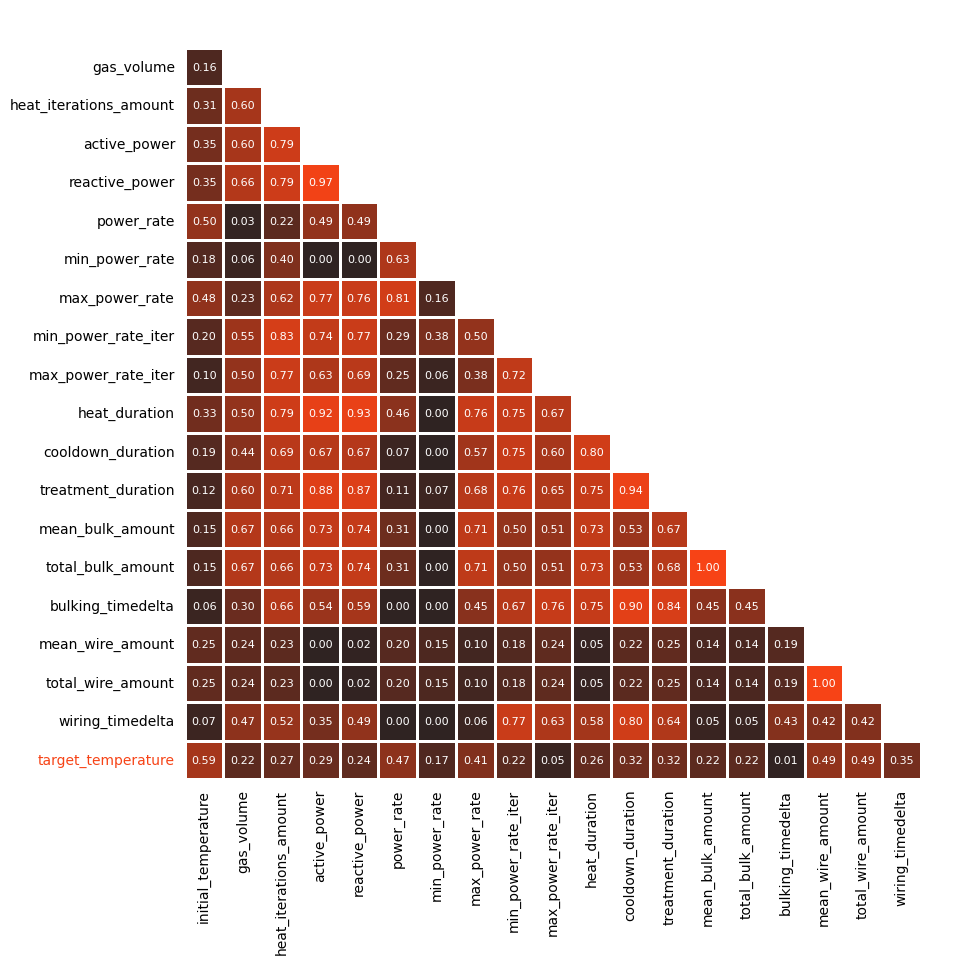

In [69]:
plt_corr(df, ['id'], ['min_power_rate_iter', 'max_power_rate_iter'])

Так как некоторые признаки создавались один, на основе другого - закономерно, что они коллинерарны. Создадим несколько списков - столбцы с самым высоким уровенм коллинеарности (только по одному из двух и более неподходящих полей), с уровнем пониже, а также столбцы "третьего уровня", для удаления из выборки только в самом крайнем случае.

In [70]:
multicollinear_cols_lvl1 = ['min_power_rate', 'max_power_rate',
                            'heat_duration', 'cooldown_duration',
                             'total_bulk_amount', 'bulking_timedelta',
                            'total_wire_amount', 'bulking_timedelta']

multicollinear_cols_lvl2 = ['heat_iterations_amount', 'min_power_rate_iter', 'max_power_rate_iter']

multicollinear_cols_lvl3 = ['active_power', 'reactive_power']

Также создадим два списка индексов для отсечения выбросов по нескольким наиболее общим колонокам.  

Пороги отсечения - 0.5 и 0.25 %% экстремальных данных для первого и второго списков соответственно.

In [71]:
bad_indexes_05 = []
bad_indexes_025 = []

for col in ['gas_volume', 'active_power', 'reactive_power', 'treatment_duration', 'total_bulk_amount', 'total_wire_amount']:
    bad_indexes_iter05 = df[df[col] > df[col].quantile(.995)].index.tolist()
    bad_indexes_05.extend(bad_indexes_iter05)

for col in ['gas_volume', 'active_power', 'reactive_power', 'treatment_duration', 'total_bulk_amount', 'total_wire_amount']:
    bad_indexes_iter025 = df[df[col] > df[col].quantile(.9975)].index.tolist()
    bad_indexes_025.extend(bad_indexes_iter025)
    
bad_indexes_05 = list(set(bad_indexes_05))
bad_indexes_025 = list(set(bad_indexes_025))

print(len(bad_indexes_05))
print(len(bad_indexes_025))

54
30


При удалении 0.5% крайних значений будет удалено 54 наблюдения,  
При удалении 0.25% крайних значений будет удалено 30 наблюдений.    

В данном разделе:  
- проведен исследовательский анализ признаков
- сформированы новые синтетические признаки
- устранены неточности в данных
- обработаны пропущенные значения
- исследован целевой признак
- подготовлен датасет для дальнейшего обучения модели  


- [К оглавлению](#0)  

## Разработка модели<a id="3"></a>
### Подготовка данных к обучению<a id="31"></a>

Отбросим стобец с идентификаторами партий, и отложим выборку, для которой нет целевых признаков.

In [ ]:
hide_code()

In [72]:
# столбец id не понадобится для обучения
df_pre_train = df.drop(['id'], axis=1)

delayed_fetch = df_pre_train[df_pre_train['target_temperature'].isna()].sample(frac=1, random_state=RANDOM_STATE)
df_pre_train = df_pre_train.drop(delayed_fetch.index)

Разобъем данные на тренировочные и тестовые в пропорции 3/1.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_pre_train
                                            .drop('target_temperature', axis=1),
                                                df_pre_train['target_temperature'],
                                                test_size=.25,
                                                shuffle=True,
                                                random_state=RANDOM_STATE
                                        )

display(X_train.head(3))
print(X_train.shape)
display(X_test.head(3))
print(X_test.shape)
display(y_train.head(3))
print(y_train.shape)
display(y_test.head(3))
print(y_test.shape)

,initial_temperature,gas_volume,heat_iterations_amount,active_power,reactive_power,power_rate,min_power_rate,max_power_rate,min_power_rate_iter,max_power_rate_iter,heat_duration,cooldown_duration,treatment_duration,mean_bulk_amount,total_bulk_amount,bulking_timedelta,mean_wire_amount,total_wire_amount,wiring_timedelta
1352,1541,8.698114,4,3.312878,2.134077,0.985525,0.349988,2.565625,2,1,876,517,1393,58.466667,877,0,5.792800,52.135201,0
2450,1597,9.613378,4,2.778482,2.163988,0.880870,0.510618,1.062313,0,3,664,1966,2630,55.466667,832,1013,17.250133,155.251197,1218
1696,1579,6.204862,4,1.601367,1.363880,0.525961,0.375999,0.727647,3,0,457,437,894,5.400000,81,0,4.446000,40.014000,0


(1852, 19)


,initial_temperature,gas_volume,heat_iterations_amount,active_power,reactive_power,power_rate,min_power_rate,max_power_rate,min_power_rate_iter,max_power_rate_iter,heat_duration,cooldown_duration,treatment_duration,mean_bulk_amount,total_bulk_amount,bulking_timedelta,mean_wire_amount,total_wire_amount,wiring_timedelta
2069,1590,7.449362,4,2.320466,1.622258,0.708605,0.398748,0.946609,2,3,729,415,1144,26.066667,391,384,11.468426,103.215836,0
131,1577,8.249673,3,2.404671,1.969881,1.036246,0.776254,1.330353,0,1,614,461,1075,40.400000,606,426,2.905760,26.151842,0
527,1629,4.768359,3,0.909518,0.672528,0.377117,0.264709,0.582684,1,0,257,1939,2196,9.800000,147,0,12.372072,111.348646,1003


(618, 19)


1352    1573
2450    1594
1696    1581
Name: target_temperature, dtype: int32

(1852,)


2069    1595
131     1576
527     1587
Name: target_temperature, dtype: int32

(618,)


Выборки подготовлены к обучению моделей. 
Тренировочная выборка состоит из 1852 наблюдений, тестовая из 618.  


- [К оглавлению](#0)  

### Автоматизация обучения<a id="32"></a>
Подготовим несколько инструментов, которые помогут обучить, проверить и подобрать гиперпараметры для разных моделей без написания дополнительного кода.

In [ ]:
hide_code()

In [74]:
service_columns = ['target_temperature']
categorical_columns = ['min_power_rate_iter', 'max_power_rate_iter']
numerical_columns = [c for c in X_train.columns if c not in categorical_columns and c not in service_columns]

In [75]:

class Predictor:
    '''
    Инструмент для обучения модели и получения прогнозов,
    принимает на вход данные и собранный пайплайн,
    может возвращать результат кроссвалидации (для получения результатов обучения)
    и обычные предсказания (для тестирования и других целей)
    
    Аргумент normalize_y позволяет нормализовать распределение целевого признака
    (преобразовывает его в обратном направлении перед возвратом предсказаний)
    '''
    
    def __init__(self, pipeline, X, y, normalize_y=False):
        self.pipeline = pipeline
        self.X = X
        self.y = y
        self.predictions = []
        self.r2_scores = []
        self.mae_scores = []
        self.normalize_y = normalize_y

    def cv_predict(self, cv=4):
        '''
        Предсказания кроссвалидацией
        '''
        try:
            kf = KFold(n_splits=cv, random_state=RANDOM_STATE)
        except:
            kf = KFold(n_splits=cv)

        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            
            if self.normalize_y:
            
                y_train_trans = boxcox(y_train + 1, 0)
                self.pipeline.fit(X_train, y_train_trans)                
                predictions = inv_boxcox(self.pipeline.predict(X_test), 0) - 1
            
            else:
                
                self.pipeline.fit(X_train, y_train)
                predictions = self.pipeline.predict(X_test)            
            
            self.predictions.extend(predictions)
            
            self.r2_scores.append(r2_score(y_test, predictions))
            self.mae_scores.append(mean_absolute_error(y_test, predictions))

        return self.predictions
    
    def get_model(self):
        '''
        Вывод обученной модели (пайплайна)
        '''
        return self.pipeline
    
    def predict(self, X):
        '''
        Получение прогноза
        '''
        self.test_predictions = self.pipeline.predict(X)        
        if self.normalize_y:
            self.test_predictions = inv_boxcox(self.test_predictions, 0) - 1
        
        return self.test_predictions
    
    def cv_r2(self):
        return self.r2_scores
    
    def cv_mae(self):
        return self.mae_scores
    
class OptunaCustomCVSearch:
    '''
    "Обёртка" для Optuna Gridsearch.
    Принимает на вход пайплайн, сетку гиперпараметров, данные
    
    '''
    
    def __init__(self, pipe, grid, X, y, cv=4, normalize_y=False):
        self.pipe = pipe
        self.grid = grid
        self.cv = cv
        self.X = X
        self.y = y
        self.normalize_y = normalize_y
        
    def objective(self, trial):
        
        grid_dictionary = {}

        for key, suggest in zip(self.grid.keys(), self.grid.values()):
            if suggest['type'] == 'int':
                grid_dictionary['regressor__'+key] = trial.suggest_int(key,
                                                         low=suggest.get('low'),
                                                         high = suggest.get('high'),
                                                         step=suggest.get('step'),
                                                         log=suggest.get('log'))
            if suggest['type'] == 'float':                
                grid_dictionary['regressor__'+key] = trial.suggest_float(key,
                                                           low=suggest.get('low'),
                                                           high = suggest.get('high'),
                                                           step=suggest.get('step'),
                                                           log=suggest.get('log'))
            if suggest['type'] == 'categorical':
                grid_dictionary['regressor__'+key] = trial.suggest_categorical(key,
                                                                 suggest.get('categories'))        

        self.pipe.set_params(**grid_dictionary)

        predictor = Predictor(self.pipe, self.X, self.y, self.normalize_y)
        predictor.cv_predict(cv=self.cv)

        score = np.mean(predictor.cv_mae())        

        return score
    
    def trials(self, n=5):
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        self.study = optuna.create_study(direction='minimize', pruner=MedianPruner())
        
        t1 = time.time()
        with tqdm(total=n) as pbar:
            def callback(study, trial):
                pbar.update(1)
            self.study.optimize(self.objective,
                           n_trials=n,
                           callbacks=[callback])
        self.timedelta = time.time() -  t1
        
        return self.study
    
    def study_history(self):
        '''
        стандартный метод optuna для отрисовки истории подбора параметров
        '''
        fig = plot_optimization_history(self.study)
        fig.show()
        
    def optimisation_history(self, threshold=None):
        '''
        новый и классный метод для отрисовки истории подбора параметров
        '''
        values = []
        steps = []
        line_values = []
        val = 1e10

        for tr in self.study.trials:
            values.append(tr.values[0])
            steps.append(tr.number)
            if tr.values[0] < val:
                val = tr.values[0]
            line_values.append(val)
            
        

        fix, ax = plt.subplots(figsize=(10, 4))
        
        values1 = [val for val in values if val < 6.5]
        steps1 = [idx for val, idx in zip(values, steps) if val < 6.5]
        values2 = [val for val in values if val >= 6.5 and val <= 6.8]
        steps2 = [idx for val, idx in zip(values, steps) if val >= 6.5 and val <= 6.8]
        values3 = [val for val in values if val > 6.8 and val < 7.5]
        steps3 = [idx for val, idx in zip(values, steps) if val > 6.8 and val < 7.5]
        values4 = [val for val in values if val >= 7.5]
        steps4 = [idx for val, idx in zip(values, steps) if val >= 7.5]
        
        sns.lineplot(x=steps, y=line_values, ls=':', color=COLORSET[1], lw=1)
        sns.scatterplot(x=steps1, y=values1, marker='.', color=COLORSET[0], s=60)
        sns.scatterplot(x=steps2, y=values2, marker='.', color=COLORSET[1], s=60)
        sns.scatterplot(x=steps3, y=values3, marker='.', color='#a3220b', s=60)
        sns.scatterplot(x=steps4, y=values4, marker='.', color=COLORSET[4], s=60)
        
        if threshold:
            plt.axhline(threshold, c=COLORSET[4], lw=.4)

        plt.ylabel('MAE')
        plt.xlabel('Итерации')
        plt.tight_layout()
        plt.show()
        plt.close()
        
    def study_summary(self):

        print(f"best value (MAE):   {self.study.best_value:.2f}")
        print("best params:")
        print(f"{self.study.best_params}")
        
    def best_value(self):
        return self.study.best_value
    
    def best_params(self):
        return self.study.best_params
    
    def time(self):
        return self.timedelta
    
    def get_study(self):
        return self.study

def pipe(scaler = None,
         encoder = None,         
         regressor = DummyRegressor(),
         num_cols=numerical_columns,
         cat_cols=categorical_columns
         ):
    
    '''
    Обертка для быстрой сборки пайплайнов
    '''

    transformers = []
    
    if scaler is not None:
        transformers.append(('numerical', scaler, num_cols))
    if encoder is not None:
        transformers.append(('categorical', encoder, cat_cols))    

    preprocessor = ColumnTransformer(transformers=transformers)

    pipeline = Pipeline(
            steps=[
                    ('preprocessor', preprocessor),
                    ('regressor', regressor)
                ]
            )
    
    return pipeline

def plt_print_metrics(preds=None, true=y_train, mae=None, r2=None):
    if preds is not None and preds.size:
        print(f'MAE: {mean_absolute_error(true, preds):.2f}\nR²: {r2_score(true, preds):.2f}')

    if mae is not None and len(mae) > 0:   
        print(f"MAE:  {np.mean(mae):.2f}  ±{np.std(mae):.2f}")
        
    if r2 is not None and len(r2) > 0:   
        print(f"R²:  {np.mean(r2):.2f}  ±{np.std(r2):.2f}")

def plt_regression_results(preds, true=y_train, mae=None, r2=None):
    
    '''
    Функция для графического сравнения результатов прогноза с истинными значениями.
    Если передать ей метрики кроссвалидации, функция также выведет ст. отклонение результатов
    '''
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    if type(preds) != pd.Series:
        preds = pd.Series(preds)
    else:
        preds = preds.reset_index(drop=True)
        
    if type(true) != pd.Series:
        true = pd.Series(true)
    else:
        true = true.reset_index(drop=True)
        

    sns.lineplot(x=[true.min(), preds.max()],
                 y=[true.min(), preds.max()], ls='-', lw=0.5, c=COLORSET[4])

    sns.kdeplot(y=true,
                  x=preds, fill=True, color=COLORSET[1], alpha=.15)

    sns.scatterplot(y=true,
                  x=preds,
                  s=30, color=COLORSET[0], marker=".", alpha=.8)

    sns.scatterplot(y=true,
                  x=preds,
                  s=30, color=COLORSET[0], marker="+", alpha=.5)


    plt.xlabel('Предсказанные значения (t °C)')
    plt.ylabel('Истинные значения (t °C)')
    plt.xticks(rotation=90)

    plt.xlim([preds.min() - 3, preds.max() + 3])
    plt.ylim([true.min() - 3, true.max() + 3])
    
    if mae is not None and len(mae) > 0:   
        local_mae = np.mean(mae)
        mae_std = np.std(mae)
        mae_text = f'MAE:  {local_mae:.2f} ±{mae_std:.2f}'        
    else:
        local_mae = mean_absolute_error(true, preds)
        mae_text = f'MAE:  {local_mae:.2f}'

    if r2 is not None and len(r2) > 0:
        local_r2 = np.mean(r2)
        r2_std = np.std(r2)
        r2_text = f'R²:  {local_r2:.2f} ±{r2_std:.2f}'
    else:
        local_r2 = r2_score(true, preds)
        r2_text = f'R²:  {local_r2:.2f}'    

    plt.xticks(rotation=90)    
    plt.text(x=0.98, y=0.02, ha='right', va='bottom', backgroundcolor='white',
             s= mae_text + '\n' + r2_text,
             transform=ax.transAxes)

    plt.tight_layout()
    plt.show()
    plt.close()
    
dummy_transformer = FunctionTransformer(lambda x: x, validate=False)

### Константная модель<a id="33"></a>  

Для начала проверим, можно ли эффективно предсказать результаты с помощью среднего.

In [76]:
pipe_dummy = pipe()

preds_dummy = cross_val_predict(pipe_dummy, X_train, y_train, cv=4)
plt_print_metrics(preds_dummy)

MAE: 9.93
R²: -0.00


MAE выше требуемого порога. R² равен нулю, как и должно быть при предсказании средним.

### Линейная регрессия<a id="34"></a>

Проверим результат для линейной регрессии.

In [ ]:
hide_code()

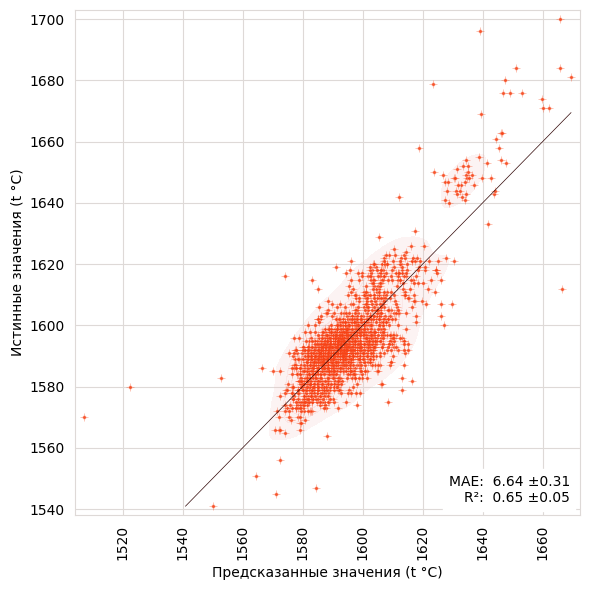

In [102]:
pipe_linear = pipe(
                RobustScaler(),
                OneHotEncoder(drop='first', handle_unknown='ignore'),                
                LinearRegression(n_jobs=-1)
            )

predictor_linear = Predictor(pipe_linear, X_train, y_train)
predictor_linear.cv_predict()

plt_regression_results(predictor_linear.cv_predict(),
                       mae=predictor_linear.cv_mae(),
                       r2=predictor_linear.cv_r2())

Качество предсказаний **на тренировочных** данных уже лучше заданного условиями порога (6.8). R2 также выше нуля, что говорит о том, что предсказания не являются случайными.    


Возможно, модель можно улучшить исключив выбросы, и нормализовав целевой признак.

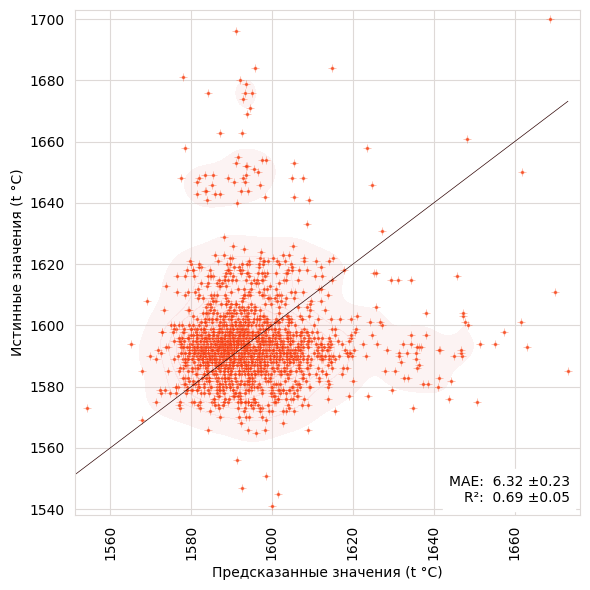

In [78]:
pipe_linear_no_outliers = pipe(
                RobustScaler(),
                OneHotEncoder(drop='first', handle_unknown='ignore'),                
                LinearRegression(n_jobs=-1)
            )

predictor_linear_no_outliers = Predictor(pipe_linear_no_outliers,
                                         X_train.drop(bad_indexes_05, errors='ignore'),
                                         y_train.drop(bad_indexes_05, errors='ignore'),
                                         normalize_y=True)
plt_regression_results(predictor_linear_no_outliers.cv_predict(),
                       mae=predictor_linear_no_outliers.cv_mae(),
                       r2=predictor_linear_no_outliers.cv_r2())

MAE как и R2 повысились. На сравнительном графике видно, что большая часть прогнозов близка к истинным значенниям. Однако, модель не очень хорошо справляется с редкими высокими значениями (около 1640-1660 на шкале истинных значений). "Облако" выбросов на прошлом графике, где рассматривалась регрессия с их учётом, было ближе к линии соответствия. Здесь же оно расположено над основным большинством значений, что означает, что модель предсказала для истинно-высоких значений - температуру близкую к средней.   


Это связано с тем, что удалив выбросы мы повысили качество предсказаний для значений, близких к среднему, но не обучили модель на эти самые выбросы.   



Тем не менее, такой подход, отчасти, оправдан, так как повышает точность предсказания тех значений - которых большинство в выборке. С этим связано и общее повышение качества предсказаний.     


Проверим также что будет если убрать часть коллинеарных значений.

In [79]:
pipe_linear_no_colinear = pipe(
                RobustScaler(),
                OneHotEncoder(drop='first', handle_unknown='ignore'),
                LinearRegression(n_jobs=-1),
        num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

predictor_linear_no_colinear = Predictor(pipe_linear_no_colinear,
                                         X_train.drop(bad_indexes_05, errors='ignore'),
                                         y_train.drop(bad_indexes_05, errors='ignore'),
                                         normalize_y=True)
predictor_linear_no_colinear.cv_predict()
plt_print_metrics(mae=predictor_linear_no_colinear.cv_mae(), r2=predictor_linear_no_colinear.cv_r2())

MAE:  6.44  ±0.27
R²:  0.68  ±0.06


В данном случае метрика немного ухудшилась.
- наилучшее достигнутое значение для линейной регрессии:
 - MAE: 6.32
 - R²: 0.69

### Случайный лес<a id="35"></a>
Проверим как работает модель случайного леса с настройками гиперпараметров по умолчанию, без удаления выбросов и коллинеарных признаков.  

Масштабирование, и какие-либо манипуляции с категориальными признаками, в случае случайного леса не требуются; поэтому в пайплайне использован заранее заготовленный `dummy transformer` который не меняет данные (просто "пропускает" их к модели).

In [ ]:
hide_code()

In [80]:
pipe_rf = pipe(
                dummy_transformer,
                dummy_transformer,
                RandomForestRegressor(random_state=RANDOM_STATE)
            )

predictor_rf = Predictor(pipe_rf,
                         X_train,
                         y_train)
predictor_rf.cv_predict()
plt_print_metrics(mae=predictor_rf.cv_mae(), r2=predictor_rf.cv_r2())

MAE:  6.22  ±0.17
R²:  0.67  ±0.03


Получен качественный результат MAE и R2.     


Попробуем такой же регрессор (со стандартными гиперпараметрами), но отбросим некоторые коллинеарные признаки и выбросы.

In [104]:
pipe_rf_improved = pipe(
                dummy_transformer,
                dummy_transformer,
                RandomForestRegressor(random_state=RANDOM_STATE),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

predictor_rf_improved = Predictor(pipe_rf_improved,
                         X_train.drop(bad_indexes_05, errors='ignore'),
                         y_train.drop(bad_indexes_05, errors='ignore'))
predictor_rf_improved.cv_predict()
plt_print_metrics(mae=predictor_rf_improved.cv_mae(), r2=predictor_rf_improved.cv_r2())

MAE:  6.08  ±0.17
R²:  0.69  ±0.03


Результат на тренировочной выборке оказался лучше.    

При этом, характер предсказаний выбивающихся из для регрессии обученной на данных с выбросами и без различается, что видно на следующих двух графиках (Random Forest Regression с учётом выбросов и без них).

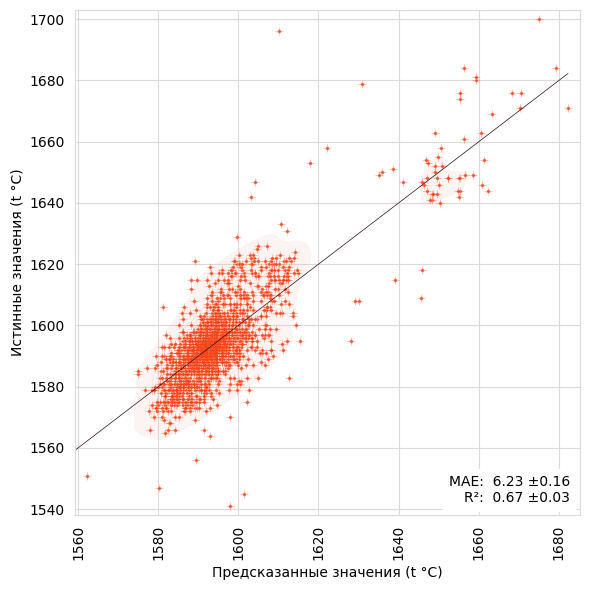

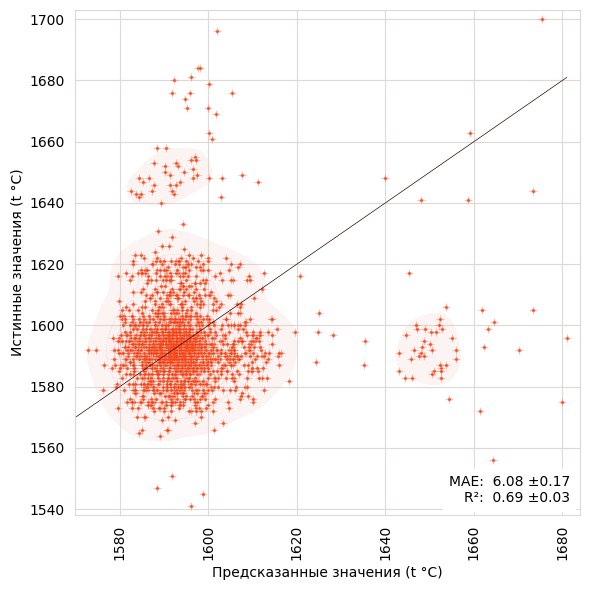

In [105]:
plt_regression_results(predictor_rf.cv_predict(),
                       mae=predictor_rf.cv_mae(),
                       r2=predictor_rf.cv_r2())

plt_regression_results(predictor_rf_improved.cv_predict(),
                       mae=predictor_rf_improved.cv_mae(),
                       r2=predictor_rf_improved.cv_r2())

Похоже, что модель, обученная на данных без выбросов не очень хорошо предсказывает высокие (редкие) значения. При этом наличие двух отдельных скоплений предсказаний по оси истинных значений и предсказаний, указывает на то, что высокие значения модель всё же предсказывает - но не в тех случаях, когда нужно.    


Подберём гиперпараметры для модели случайного леса.  


<div style="border:solid black 1px; padding: 20px">
Здесь и далее подбор гиперпараметров оставлен для наглядности процесса - для обучения моделей используются уже подобранные гиперпараметры, вынесенные в словари ниже.    
<br>
    
При перезапуске кода результат работы optuna может отличаться от результата, достигнутого с сохранёнными гиперпараметрами. В случае, если он окажется лучше - он будет использован для обучения модели. 

  0%|          | 0/80 [00:00<?, ?it/s]

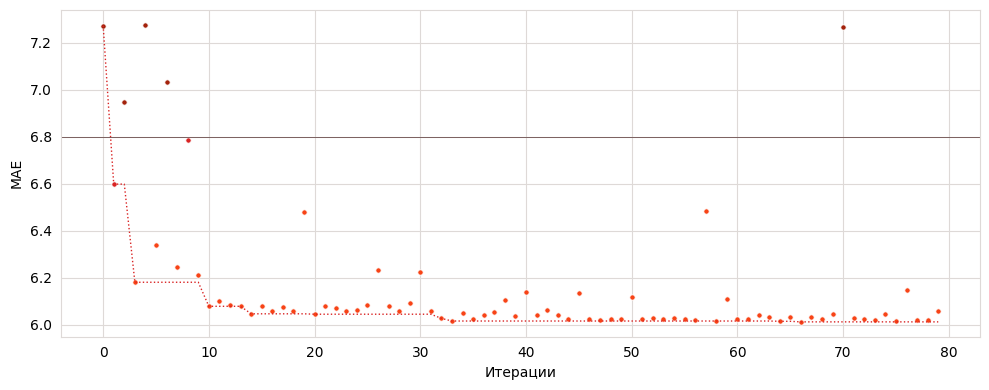

best value (MAE):   6.01
best params:
{'n_estimators': 248, 'max_depth': 14, 'max_features': 12, 'min_samples_leaf': 1, 'random_state': 260722, 'criterion': 'squared_error'}
finished in 17 min


In [83]:
pipe_rf_improved_gs = pipe(
                dummy_transformer,
                dummy_transformer,
                RandomForestRegressor(random_state=RANDOM_STATE),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

rf_grid = {
            'n_estimators': {'type': 'int', 'low': 50, 'high': 250, 'step': 1, 'log': True},
            'max_depth': {'type': 'int', 'low': 3, 'high': 16, 'step': 1, 'log': False},
            'max_features': {'type': 'int', 'low': 3, 'high': X_train.shape[1], 'step': 1, 'log': False},
            'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 5, 'step': 1, 'log': False},
            'random_state': {'type': 'int', 'low': RANDOM_STATE, 'high': RANDOM_STATE, 'step': 1, 'log': False},
            'criterion': {'type': 'categorical', 'categories': ['absolute_error', 'friedman_mse', 'squared_error']}
        }

rf_cv = OptunaCustomCVSearch(pipe_rf_improved_gs,
                             rf_grid,
                             X=X_train.drop(bad_indexes_05, errors='ignore'),
                             y=y_train.drop(bad_indexes_05, errors='ignore'))
rf_cv.trials(80)

rf_cv.optimisation_history(MAE_THRESHOLD)
rf_cv.study_summary()
print(f"finished in {rf_cv.time() // 60:.0f} min")



Проверим модель с помощью кроссвалидации на тренировочных данных.

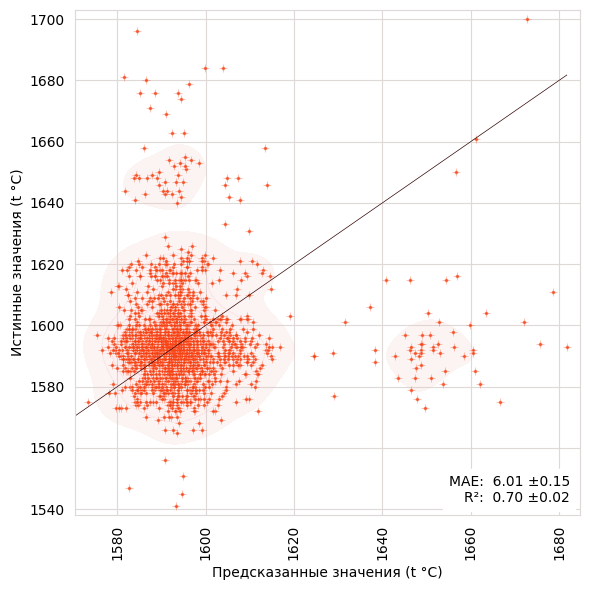

In [84]:
rf_best_mae = 6.01

rf_best_params = {'n_estimators': 229,
                  'max_depth': 14,
                  'max_features': 17,
                  'min_samples_leaf': 1,
                  'random_state': 260722,
                  'criterion': 'friedman_mse'}

try: 
    if rf_cv.best_value() < rf_best_mae:
        rf_best_params = rf_cv.best_params()
    else:
        pass
except:
    pass
        
        

pipe_rf_best = pipe(
                dummy_transformer,
                dummy_transformer,
                RandomForestRegressor(**rf_best_params),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

predictor_pipe_rf_best = Predictor(pipe_rf_best,
                                   X_train.drop(bad_indexes_05, errors='ignore'),
                                   y_train.drop(bad_indexes_05, errors='ignore'))
pred_rf_best = predictor_pipe_rf_best.cv_predict()
plt_regression_results(pred_rf_best,
                       mae=predictor_pipe_rf_best.cv_mae(),
                       r2=predictor_pipe_rf_best.cv_r2())

Наилучшая достигнутая метрика для Random Forest Regressor'а на тренировочной выборке:
- MAE = 6.01 со стандартным отклонением 0.15 
- R2 = 0.7


### Бустинг XG Boost<a id="36"></a>  

Попробуем в деле один из популярных бустингов - XGBoost
(подбор гиперпараметров также осуществелён для демонстрации - наилучшие гиперпараметры уже сохранены в переменную ниже)

In [ ]:
hide_code()

  0%|          | 0/80 [00:00<?, ?it/s]

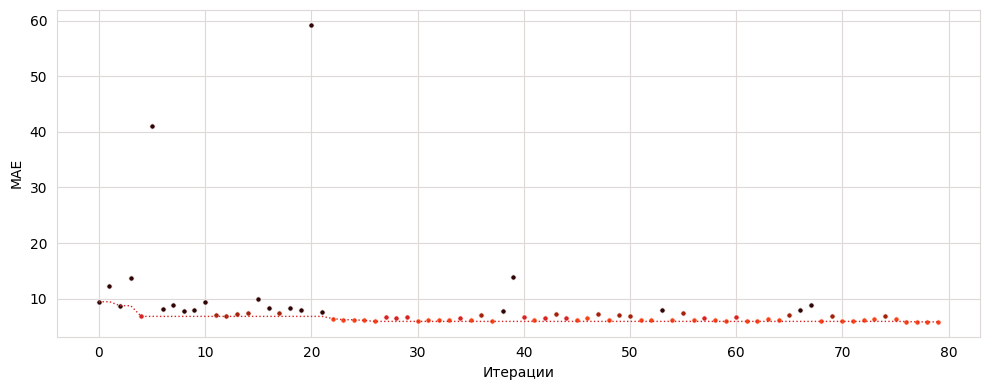

best value (MAE):   5.81
best params:
{'n_estimators': 220, 'max_depth': 3, 'learning_rate': 0.00038318350477661, 'subsample': 0.714158235676822, 'colsample_bytree': 0.9375690738013461, 'seed': 260722, 'objective': 'reg:absoluteerror', 'reg_alpha': 0.0034988655189196805}
None

finished in 2 min


In [85]:
xgb_columns = numerical_columns
xgb_columns.extend(categorical_columns)

pipe_xgb = pipe(
                MaxAbsScaler(),
                None,
                XGBRegressor(),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

xgb_grid = {
            'n_estimators': {'type': 'int', 'low': 50, 'high': 250, 'step': 1, 'log': True},
            'max_depth': {'type': 'int', 'low': 3, 'high': 16, 'step': 1, 'log': False},
            'learning_rate': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},
            'subsample': {'type': 'float', 'low': .4, 'high': 1},
            'colsample_bytree': {'type': 'float', 'low': .1, 'high': 1},
            'seed': {'type': 'int', 'low': RANDOM_STATE, 'high': RANDOM_STATE, 'step': 1, 'log': False},
            'objective': {'type': 'categorical', 'categories': ['reg:absoluteerror']},
            'reg_alpha': {'type': 'float', 'low': 1e-4, 'high': 1, 'log': True},
        }

xgb_cv = OptunaCustomCVSearch(pipe_xgb, xgb_grid,
                               X_train.drop(bad_indexes_05, errors='ignore'),
                               y_train.drop(bad_indexes_05, errors='ignore'), normalize_y=True)
xgb_cv.trials(80)

xgb_cv.optimisation_history()
print(xgb_cv.study_summary())
print()
print(f"finished in {xgb_cv.time() // 60:.0f} min")

Проверим модель с помощью кроссвалидации на тренировочных данных.

MAE:  5.81  ±0.21
R²:  0.72  ±0.02


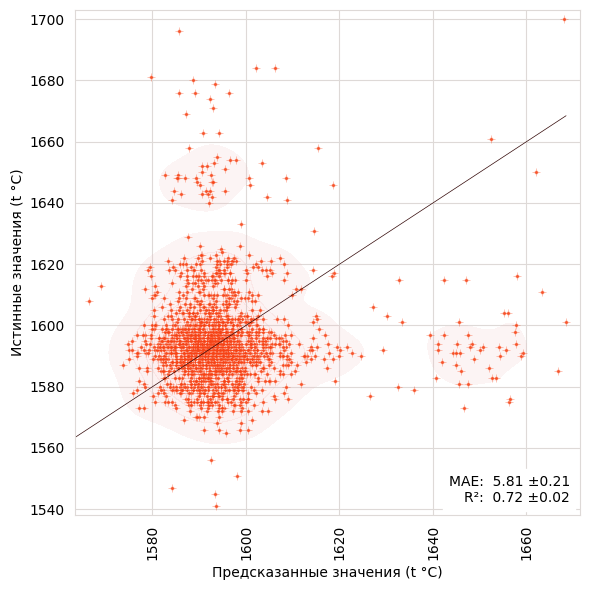

In [86]:
xgb_best_mae = 5.81

xgb_best_params = {'n_estimators': 220,
                   'max_depth': 3,
                   'learning_rate': 0.00038318350477661,
                   'subsample': 0.714158235676822,
                   'colsample_bytree': 0.9375690738013461,
                   'seed': 260722,
                   'objective': 'reg:absoluteerror',
                   'reg_alpha': 0.0034988655189196805}
    
try: 
    if xgb_cv.best_value() < xgb_best_mae:
        xgb_best_params = xgb_cv.best_params()
    else:
        pass
except:
    pass

pipe_xgb_best = pipe(
                MaxAbsScaler(),
                None,
                XGBRegressor(**xgb_best_params),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

predictor_xgb_best = Predictor(pipe_xgb_best,
                               X_train.drop(bad_indexes_05, errors='ignore'),
                               y_train.drop(bad_indexes_05, errors='ignore'), normalize_y=True)

pred_xgb_best = predictor_xgb_best.cv_predict()
plt_regression_results(pred_xgb_best, y_train,
                       mae=predictor_xgb_best.cv_mae(),
                       r2=predictor_xgb_best.cv_r2())

Наилучшая достигнутая метрика для регрессора XGBoost на тренировочной выборке:
- MAE = 5.81 со стандартным отклонением 0.21
- R2 = 0.72

Целевая метрика оказалась лучше, чем у случайного леса, однако стандартное отклонение валидаций выше. То есть, возможны валидации с более высоким MAE, однако возможны и валидации с ошибкой около 5.6.

### Бустинг LightGBM<a id="37"></a>
Опробуем ещё один бустинг LightGBM, который отличает высокая скорость работы.

  0%|          | 0/80 [00:00<?, ?it/s]

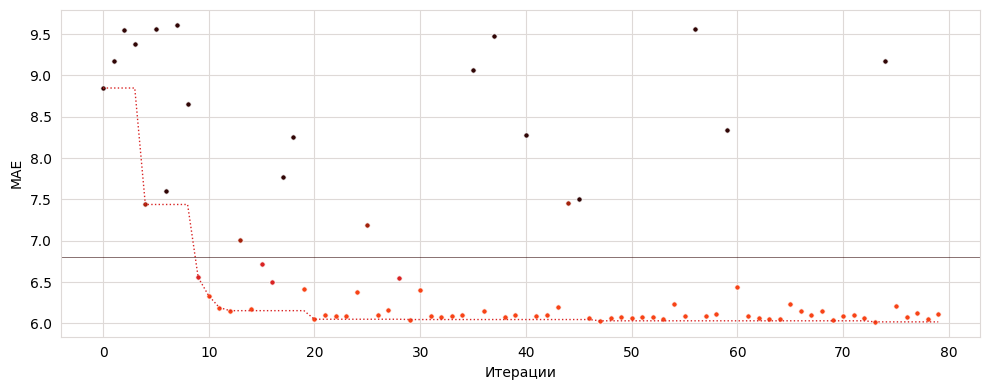

best value (MAE):   6.02
best params:
{'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.06442261153365891, 'num_leaves': 41, 'seed': 260722, 'objective': 'mae', 'reg_alpha': 0.009011808730042346, 'reg_lambda': 0.009148784340787943, 'verbose': -1}
None

finished in 3 min


In [87]:
pipe_lgbm = pipe(
                dummy_transformer,
                None,
                LGBMRegressor(),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )

lgbm_grid = {
            'n_estimators': {'type': 'int', 'low': 50, 'high': 250, 'step': 1, 'log': True},
            'max_depth': {'type': 'int', 'low': 3, 'high': 16, 'step': 1, 'log': False},
            'learning_rate': {'type': 'float', 'low': 1e-4, 'high': 1e-1, 'log': True},
            'num_leaves': {'type': 'int', 'low': 10, 'high': 300, 'step': 1, 'log': False},
            'seed': {'type': 'int', 'low': RANDOM_STATE, 'high': RANDOM_STATE, 'step': 1, 'log': False},
            'objective': {'type': 'categorical', 'categories': ['mae']},
            'reg_alpha': {'type': 'float', 'low': 1e-4, 'high': 1, 'log': True},
            'reg_lambda': {'type': 'float', 'low': 1e-4, 'high': 1, 'log': True},
            'verbose': {'type': 'categorical', 'categories': [-1]},
        }

lgbm_cv = OptunaCustomCVSearch(pipe_lgbm, lgbm_grid, X=X_train, y=y_train, normalize_y=True)
lgbm_cv.trials(80)

lgbm_cv.optimisation_history(MAE_THRESHOLD)
print(lgbm_cv.study_summary())
print()
print(f"finished in {lgbm_cv.time() // 60:.0f} min")

Проверим модель с помощью кроссвалидации на тренировочных данных.

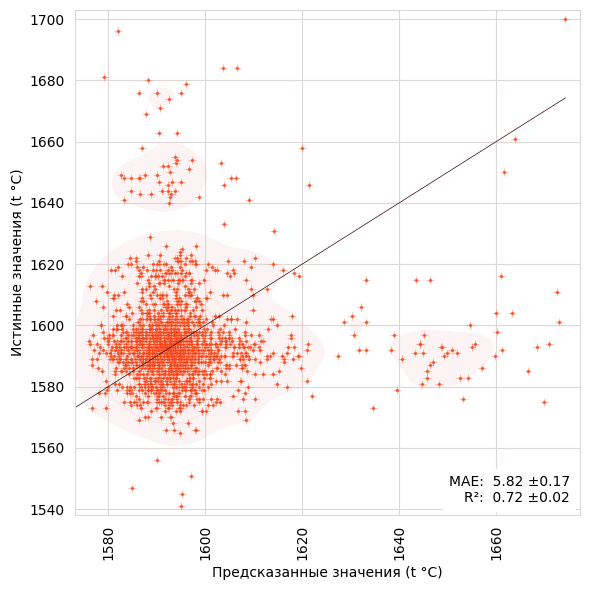

In [106]:
lgbm_best_mae = 5.82

lgbm_best_params = {'n_estimators': 234,
                    'max_depth': 16,
                    'learning_rate': 0.07166065479990444,
                    'num_leaves': 14,
                    'seed': 260722,
                    'objective': 'mae',
                    'reg_alpha': 0.0164850811134795,
                    'reg_lambda': 0.0016060283757459738,
                    'verbose': -1}

try: 
    if lgbm_cv.best_value() < lgbm_best_mae:
        lgbm_best_params = lgbm_cv.best_params()
    else:
        pass
except:
    pass

pipe_lgbm_best =pipe(
                dummy_transformer,
                None,
                LGBMRegressor(**lgbm_best_params),
                num_cols=[c for c in numerical_columns if c not in multicollinear_cols_lvl1]
            )


predictor_lgbm_best = Predictor(pipe_lgbm_best,
                                X=X_train.drop(bad_indexes_05, errors='ignore'),
                                y=y_train.drop(bad_indexes_05, errors='ignore'),
                                normalize_y=True)

pred_lgbm_best = predictor_lgbm_best.cv_predict()
plt_regression_results(pred_lgbm_best, y_train,
                       mae=predictor_lgbm_best.cv_mae(),
                       r2=predictor_lgbm_best.cv_r2())

Наилучшая достигнутая метрика для регрессора LightGBM на тренировочной выборке:
- MAE = 5.82 со стандартным отклонением 0.17
- R2 = 0.72

Результат почти не отличается от результата XGBoost, метрика абсолютной ошибки чуть выше, однако стандартное отклонение метрики чуть ниже, что говорит о более стабильном результате.  


- [К оглавлению](#0)  

### Нейросеть прямого распространения<a id="38"></a> 

Также попробуем спрогнозировать температуру сплава с помощью нейросети. 

<div style="border:solid black 1px; padding: 20px">
В данной конфигурации не используется ранняя остановка. Вместо этого чекпойнт состояния весов с лучшей метрикой сохраняется, и предсказание осуществляется загруженной моделью.

In [ ]:
hide_code()

In [110]:
class Net:

    def __init__(self,
                 layers_cnt = 3,
                 optimizer_lr = 0.001,
                 batch_size = 1000,
                 epochs = 100,
                 verbose = 1,
                 # early_stop_patience = 10,
                 units_list=None,
                 units_divider_list=[4, 16, 40, 100, 500],
                 lr_list=[0.025, 0.025, 0.025, 0.025, 0.025],
                 scaler=None,
                 normalize_y = False
                ):
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.input_n = X_train.shape[1]
        # self.early_stop_patience = early_stop_patience
        self.layers_cnt = layers_cnt
        self.optimizer_lr = optimizer_lr
        self.units_list=units_list
        self.units_divider_list=units_divider_list
        self.lr_list=lr_list
        self.scaler = scaler
        self.normalize_y = normalize_y

        if not self.units_list:
            self.units_list = [self.input_n // i for i in self.units_divider_list]

    # инициализация сети
    def build(self):
        optimizer = Adam(learning_rate=self.optimizer_lr)

        leaky_relu = LeakyReLU(alpha=0.2)

        model = Sequential()

        model.add(Dense(units = self.units_list[0],
                        input_shape=(self.input_n,),
                        activation='relu',
                        # kernel_regularizer=l2(self.lr_list[0]),
                        kernel_initializer='he_normal'
                       )
                 )

        for i in range(self.layers_cnt-1):
            model.add(BatchNormalization())
            model.add(Dense(units = self.units_list[i + 1],
                        activation=leaky_relu,
                        # kernel_regularizer=l2(self.lr_list[i + 1]),
                        kernel_initializer='he_normal'
                       )
                 )
        model.add(BatchNormalization())
        model.add(Dense(1,
                        activation='linear'
                       )
                 )

        model.compile(loss='mean_absolute_error', metrics='mean_absolute_error', optimizer=optimizer)

        self.model = model
        return self.model

    # вывод информации
    def summary(self):
        return self.build().summary()

    # обучение
    def train(self, X_train=X_train, y_train=y_train,
              steps_per_epoch=None, validation_steps=None):        
        
        tf_random.set_seed(RANDOM_STATE)
        np.random.seed(RANDOM_STATE)
        random.seed(RANDOM_STATE)        

        self.X_train = X_train        
        self.y_train = y_train
        if self.normalize_y:            
                self.y_train = boxcox(y_train + 1, 0)        
        self.steps_per_epoch = steps_per_epoch
        self.validation_steps = validation_steps
                
        X_train, X_val, y_train, y_val = train_test_split(self.X_train, self.y_train,
                                                test_size=.25,
                                                shuffle=True,
                                                random_state=RANDOM_STATE
                                        )        
        if self.scaler:
                X_train = self.scaler.fit_transform(X_train)
                X_val = self.scaler.transform(X_val)                
        

        model = self.build()
        checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

        self.history = model.fit(
                        x=X_train,
                        y=y_train,
                        validation_data=(X_val, y_val),
                        batch_size=self.batch_size,
                        epochs=self.epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        verbose = self.verbose,
                        callbacks=[checkpoint]
                    )

        self.model = model
        return model
   
    # вывод истории обучения
    def train_history(self):
        return self.history.history
    
    # предсказание (для теста)
    def predict(self, X):
        self.X = X
        return self.model.predict(self.X).flatten()

###### Конфигурация сети
- 3 слоя
- 8, 4 и 3 нейрона на слоях
- длительность обучения: 700 эпох
- размер батча: 200

In [90]:
net = Net(
          layers_cnt=3,
          optimizer_lr=0.0073,
          batch_size=200,
          epochs=700,
          units_list=[8, 4, 3],
          verbose=0)
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 160       
                                                                 
 batch_normalization (Batch  (None, 8)                 32        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 batch_normalization_1 (Bat  (None, 4)                 16        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 3)                 15        
                                                                 
 batch_normalization_2 (Bat  (None, 3)                 1

###### Обучение нейросети

In [91]:
t1 = time.time()
net.train(X_train=X_train, y_train=y_train)
print(f"done in {time.time() - t1:.0f} sec")

done in 69 sec


Ознакомимся с прогрессом обучения.

In [116]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=net.train_history()['val_mean_absolute_error'],
                         x=[i for i in range(len(net.train_history()['val_mean_absolute_error']))],
                         line={'color': COLORSET[0], 'width': 1},
                         name='валидационная ошибка'))

fig.add_trace(go.Scatter(y=net.train_history()['mean_absolute_error'],
                         x=[i for i in range(len(net.train_history()['mean_absolute_error']))],
                         line={'color': COLORSET[4], 'width': 1},
                         name='тренировочная ошибка'))

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(type='buttons',yanchor='bottom',
                             xanchor='left', y=0.02, x=0.01, showactive=True,
            buttons=[go.layout.updatemenu.Button(args=[{'yaxis.type': 'linear'}],
                                            label='линейная\nшкала',
                                            method='relayout'),
                     go.layout.updatemenu.Button(args=[{'yaxis.type': 'log'}],
                                            label='логарифмическая\nшкала',
                                            method='relayout')])
        ]
    )

fig.update_layout(  template=None, plot_bgcolor='white', paper_bgcolor='white',
                    margin = dict(t=10, l=60, r=10, b=60),
                    legend=dict(yanchor='top', y=1, x=0.5,
                              xanchor='center',
                              title_text='MAE',
                                bgcolor='#f0e5dd'),                  
                    xaxis=dict(
                            gridcolor='#ded9d7',
                            zerolinecolor='#ded9d7',
                            color=COLORSET[4],
                            showticklabels=True,
                            ticks='outside',
                            title='Эпохи',
                            showline=True,
                            ),
                    yaxis=dict(
                        gridcolor='#ded9d7',
                        zerolinecolor='#ded9d7',
                        color=COLORSET[4],
                        showticklabels=True,
                        ticks='outside',
                        title='MAE',
                        showline=True))

fig.show()

print(f"Лучшая метрика, полученная в ходе обучения на валидации - MAE: \u001b[30;1m{min(net.train_history()['val_mean_absolute_error']):.2f}")

Лучшая метрика, полученная в ходе обучения на валидации - MAE: 6.14


Удовлетворительный результат (MAE 6.14) получен приблизительно на 400 эпохе.   


In [93]:
net_best = load_model("best_model.h5")
net_preds = net_best.predict(X_train).flatten()

58/58 [==============================] - 0s 2ms/step


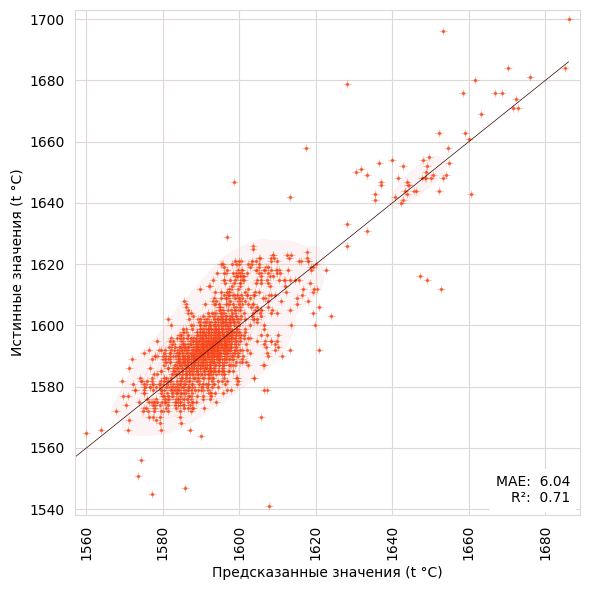

In [94]:
plt_regression_results(net_preds, true=y_train)

Если провести предсказания на всей тренировочной выборке, наилучшая метрика для нейросети на тренировочной выборке:
- MAE = 6.04
- R2 = 0.71


Метрики не имеют стандартного отклонения, так как, в отличие от других моделей, сеть обучалась на части транировочной выборки, а другую часть использовала как валидационную. Логика разделения выборки заложена в архитектуру модели.

Абсолютная ошибка на валидации, как указано выше, составляет **6.14** 


#### Итоги выбора модели<a id="39"></a>

In [254]:
all_models_result = pd.DataFrame({
        'Model': ['Constant Predictions', 'Linear Regression',
                  'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network'],
        'MAE': [9.93, 6.32, 6.01, 5.81, 5.82, 6.14],
        'R²': [0, 0.68, 0.7, 0.72, 0.72, 0]
        })

fig = make_subplots(rows=1, cols=2, horizontal_spacing = 0, specs=[[{"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Bar(y=all_models_result['Model'],
                     x=all_models_result['R²'],
                     name='R²', orientation='h',
                     marker=dict(color=COLORSET[1])                
                    ), row=1, col=1, secondary_y=False)

fig.add_trace(go.Bar(y=all_models_result['Model'],
                     x=all_models_result['MAE'],
                     name='MAE', orientation='h',
                     text=all_models_result['Model'],
                     textposition='auto',
                     insidetextanchor='start', 
                     marker=dict(color=COLORSET[0])                
                    ), row=1, col=2, secondary_y=False)

fig['layout']['xaxis']['autorange'] = "reversed"

fig.update_traces(hovertemplate='<b>%{x}</b>', row=1, col=1)
fig.update_traces(hovertemplate='<b>%{x:.2f}</b>', row=1, col=2)

common_graph_setting = dict(gridcolor='#ded9d7',
                            zerolinecolor='#ded9d7',
                            color=COLORSET[4],                            
                            ticks='outside',                            
                            showline=True)
fig.update_xaxes(common_graph_setting, showticklabels=True, title='R²',row=1, col=1)
fig.update_yaxes(common_graph_setting, showticklabels=False, title='',row=1, col=1)
fig.update_xaxes(common_graph_setting, showticklabels=True, title='MAE',row=1, col=2)
fig.update_yaxes(common_graph_setting, showticklabels=False, title='',row=1, col=2)

fig.update_layout(height=300,  template=None, plot_bgcolor='white', paper_bgcolor='white',
                    margin = dict(t=20, l=10, r=10, b=50),
                    legend=dict(yanchor='bottom', y=0, x=0,
                              xanchor='left', orientation='h',
                              title_text='Метрики:',
                              bgcolor='#f0e5dd')
                 )
fig.show()

**Наилучший результат** при кроссвалидации на тренировочной выборке показал бустинг **XGBoost** с подобранными гиперапараметрами, обученный на данных без выбросов, колинеарных признаков и с нормализованным (в процессе обучения) целевым признаком.     

Также хороший результат у бустинга LightGBM, удовлетворительные результаты на тренировочной выборке показывает Random Forest Regressor и нейронная сеть.

<div style="border:solid black 1px; padding: 20px">
В отличие от других моделей, результат которых получен при кроссвалидации, для нейросети указан только лучший результат на валидационной выборке (которая выделяется из тренировочной "временно", в процессе работы сети). Коэффициент детерминации в процессе обучения для нейросети не измерялся.

По результатам подбора моделей выберем для тестирования **XGBoost**.  


- [К оглавлению](#0)  

## Тестирование<a id="4"></a> 

Проверим работу обученного ранее пайплайна с регрессором XGBoost на тестовой выборке.   

Конфигурация пайплайна:   
- модель: XGBoost Regressor
- числовые признаки: масштабированы MaxAbsScaler()
- категориальные признаки: отсутствуют
- удалены коллиенартные признаки 1 уровня (часть коллинеарных признаков)
- удалены выбросы, попадающие в 0.5% самых высоких значений
- нормализовано распределение целевого признака

In [ ]:
hide_code()

Результат тестирования бустинга xgBoost:


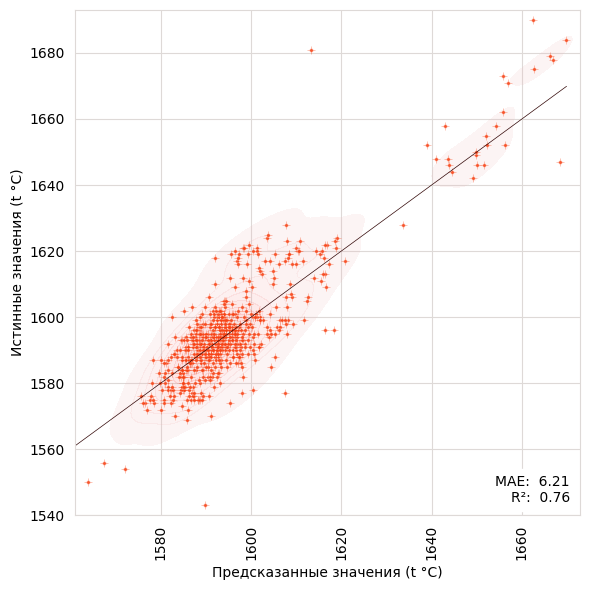


Результат тестирования константной модели (предсказание средним значением):
MAE: 11.15
R²: -0.00


In [118]:
test_preds_xgb = predictor_xgb_best.predict(X_test)
print("Результат тестирования бустинга xgBoost:")
plt_regression_results(test_preds_xgb, y_test)


print()
print("Результат тестирования константной модели (предсказание средним значением):")
pipe_dummy_test = pipe()
preds_dummy_test = cross_val_predict(pipe_dummy_test, X_test, y_test, cv=4)
plt_print_metrics(preds_dummy_test, y_test)

Модель хорошо прогнозирует тестовые данные. Средняя абсолютная ошибка составляет 6.21, что ниже заданного условиями порога. Коэффициент детерминации 0.76, что не намного выше, чем у аналогичной модели на тренировочной выборке.   

При сопоставлении с истинными значениями на графике видно, что большинство значений находятся близко к линии соответствия. Лишь несколько смещены на значительное расстояние. 

Результат регрессии лучше, чем у константной модели - прогнозирование средним значением на тестовой выборке дает MAE более 11.   

Также можно сопоставить распределения предсказаний и истинных значений.

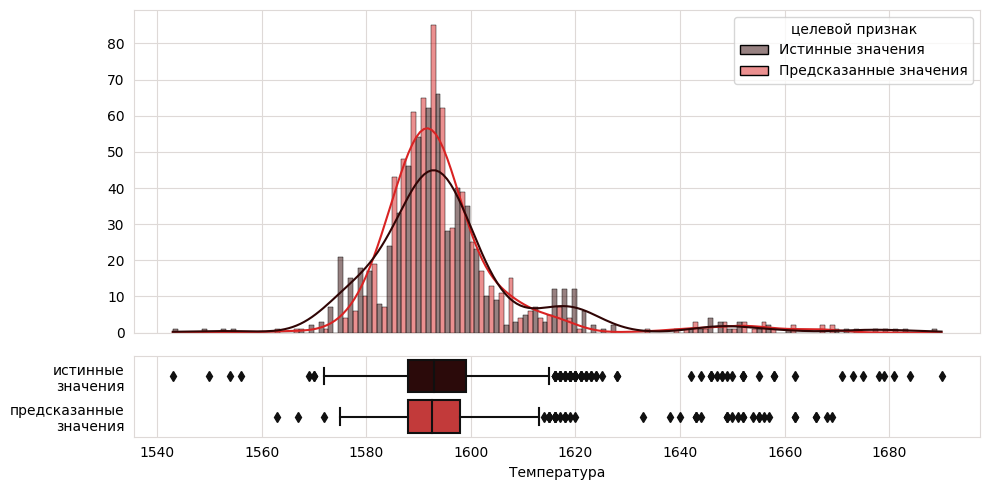

In [231]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, height_ratios=[4, 1])

palette1 = sns.color_palette([COLORSET[4], COLORSET[1]])

results_distr_data = (
        pd.DataFrame(
                    {'Истинные значения': y_test,
                     'Предсказанные значения': test_preds_xgb}
                    )
                .astype(int)
                .melt()
                .rename(columns={'variable': 'целевой признак'})
    )

sns.histplot(
        data=results_distr_data,
        x='value',
        hue='целевой признак',
        multiple='dodge',
        kde=True,
        palette=palette1,
        ax=ax[0]
    )

sns.boxplot(data=results_distr_data,
        x='value',
        palette=palette1,
        y='целевой признак', ax=ax[1])

# plt.subplots_adjust(hspace = 0.02)
plt.xlabel('Температура')
plt.ylabel('')
plt.yticks(ticks=[0, 1], labels=['истинные\nзначения', 'предсказанные\nзначения'])


plt.sca(ax[0])
plt.ylabel('')
plt.tight_layout()
plt.show()
plt.close()

Распределение предсказанных значений более "сжато" вокруг среднего, то есть модель стремится чаще предсказывать близкое к среднему значение. Тем не менее в правой части гистограммы видно, что модель успешно справляется и с высокими значениями.   

В целом, форма распределения предсказаний близка к форме распределения истинных значений.

#### Итог тестирования
Выбранная модель (градиантный бустинг XGBoost) показал хорошее качество прогнозирования как на тренировочной так и на тестовой выборке. Предсказания близки к истинным значениям. Средняя абсолютная ошибка при тестировании составляет $6.21$, коэффициент детерминации - $0.76$  


- [К оглавлению](#0)  

## Важность признаков<a id="5"></a>

###### Важность признаков XGBoost
Проанализируем важность признаков с помощью стандартного инструментария XGBoost. Сортируем признаки от внёсших наибольший вклад в предсказание модели, к внёсшим наименьший вклад.

In [278]:
hide_code()

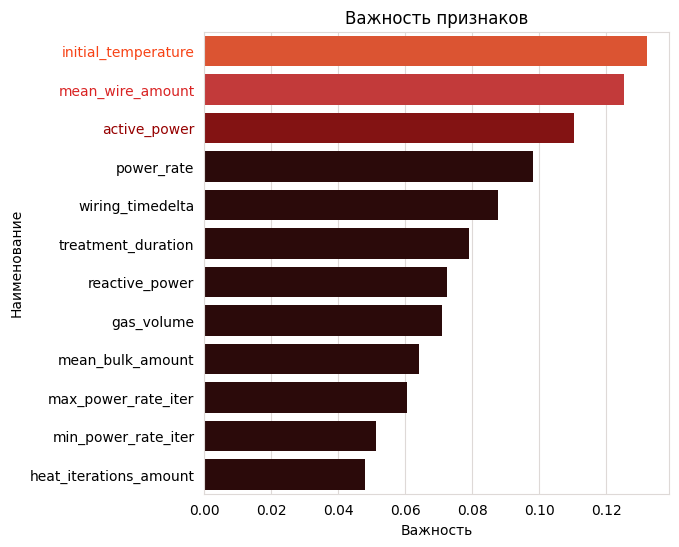

In [97]:
xgb_importances = pd.DataFrame(
        {'feature': [c for c in numerical_columns if c not in multicollinear_cols_lvl1],
         'importance': predictor_xgb_best
                         .get_model()
                         .named_steps['regressor']
                         .feature_importances_}
        )

importances_cmap = [COLORSET[4] for i in range(len(X_train.columns))]
importances_cmap[0] = COLORSET[0]
importances_cmap[1] = COLORSET[1]
importances_cmap[2] = '#960000'

fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(data=xgb_importances.sort_values('importance', ascending=False),
            x='importance', y='feature',
           palette=importances_cmap
           
           )

ax.yaxis.get_ticklabels()[0].set_color(COLORSET[0])
ax.yaxis.get_ticklabels()[1].set_color(COLORSET[1])
ax.yaxis.get_ticklabels()[2].set_color('#960000')

plt.ylabel('Наименование')
plt.xlabel('Важность')
plt.title('Важность признаков')

plt.show()
plt.close()

Три самых важных признака, согласно результатам анализа:
- Начальная температура
- средний объем поданного легировочного материала (порошковой проволоки)
- активная мощность  

Также для предсказаний важны полная мощность, время добавления порошковой проволоки, общая длительность обработки, и т.д. по убывающей.

###### Важность признаков SHAP   

Также оценим важность признаков с помощью библиотеки SHAP.

In [98]:
background = shap.kmeans(X_train[xgb_importances['feature'].tolist()], 5)

shap_explainer = shap.KernelExplainer(predictor_xgb_best
                         .get_model()
                         .named_steps['regressor'].predict
                                      , background)
shap_values = shap_explainer.shap_values(X_test[xgb_importances['feature'].tolist()])

  0%|          | 0/618 [00:00<?, ?it/s]

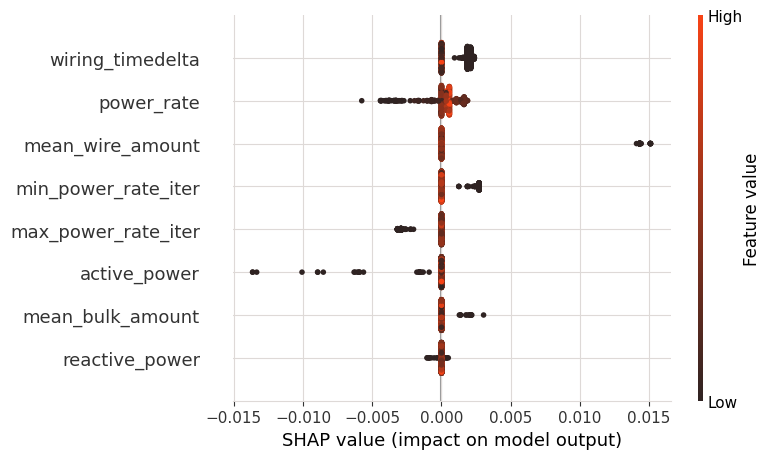

In [233]:
shap_cmap = ListedColormap(
            sns.color_palette(f"dark:{COLORSET[0]}", n_colors=256).as_hex()
        )

fig  = plt.figure()
shap.summary_plot(shap_values, X_test[xgb_importances['feature'].tolist()], cmap=shap_cmap, max_display=8)
plt.show()
plt.close()

По версии Shap в числе наиболее влиятельных признаков - **время между добавлениями в сплав порошковой проволоки**; многие низкие показатели (то есть короткое время между итерациями легирования) повышают прогноз температуры.    

Также вклад в важность признаков вносит **полная мощность** - низкие значения мощности понижают прогнозируемую температуру, высокие напротив повышают; вклад повышенных значений мощности четко выражен, но его масштаб не велик. Иначе говоря, полная мощность точно вносит вклад в прогноз, однако это не даёт значительных смещений предсказания.    

**Средний объем добавленной проволоки** в целом не вносит вклада в изменение прогноза, однако есть несколько эпизодов, когда низкие значения объема проволоки значительно смещали прогноз в сторону повышения температуры.   

Аналогичный эффект, но в сторону понижения температуры, вносят отдельные предсказания **активной мощности**.   

###### Важные признаки

По совокупности двух методов анализа важных признаков исследуем связь трёх наиболее важных из них и целевого признака. Также исследуем как влияет на результат общее время обработки стали (это не является важнейним признаком, однако оценить параметр можно с точки зрения отсутствия коллинеарности с тремя другими, так как -к примеру- полная мощность или время добавления легировочного материала будут сонапреавлены с другими исследуемыми признаками.
- начальная температура 
- активная мощность
- средний объем добавленной порошковой проволоки (0 если не добавлялась)
- общее время обработки

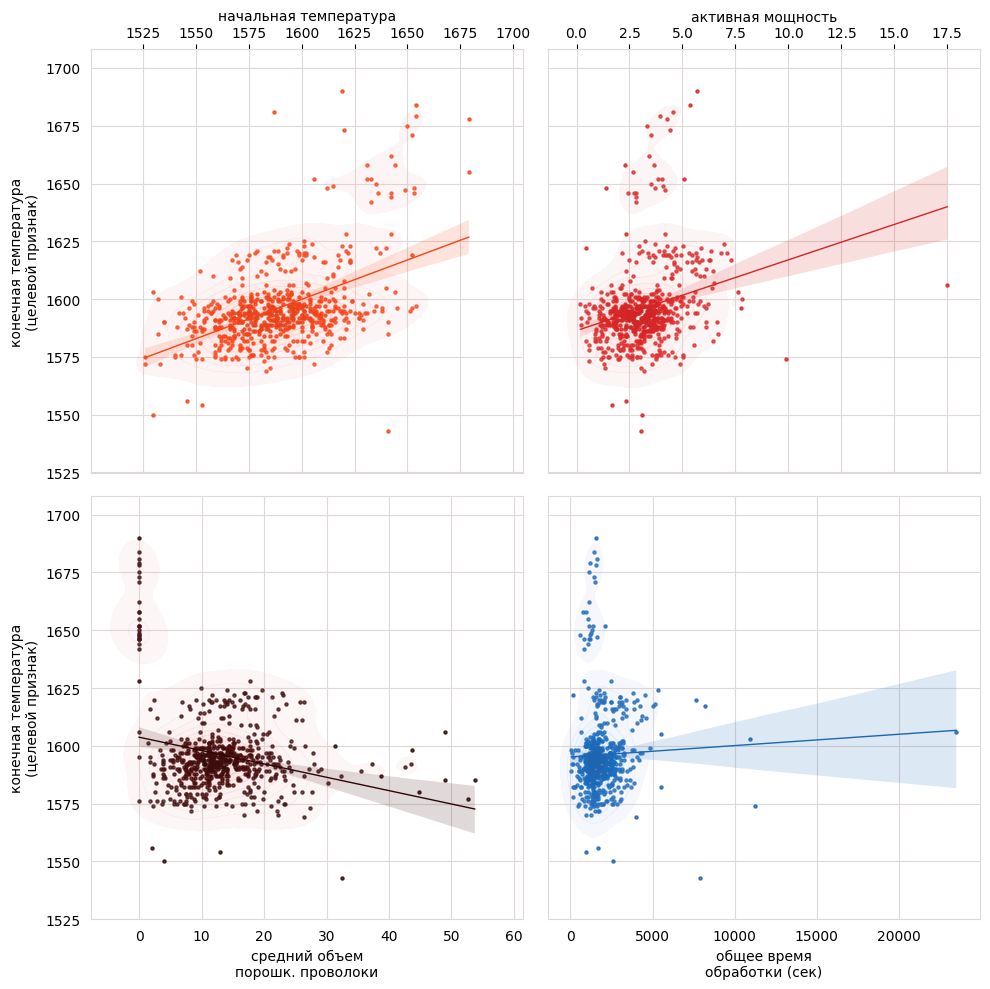

In [251]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

sns.regplot(X_test, x='initial_temperature', y=y_test,
            marker='.', scatter_kws={'s': 20}, line_kws={'lw': 1},
            color=COLORSET[0], ax=ax[0, 0])
sns.regplot(X_test, x='active_power', y=y_test,
            marker='.', scatter_kws={'s': 20}, line_kws={'lw': 1},
            color=COLORSET[1], ax=ax[0, 1])
sns.regplot(X_test, x='mean_wire_amount', y=y_test,
            marker='.', scatter_kws={'s': 20}, line_kws={'lw': 1},
            color=COLORSET[4], ax=ax[1, 0])
sns.regplot(X_test, x='treatment_duration', y=y_test,
            marker='.', scatter_kws={'s': 20}, line_kws={'lw': 1},
            color=COLORSET[2], ax=ax[1, 1])

sns.kdeplot(X_test, x='initial_temperature', y=y_test,
            fill=True, alpha=.12, color=COLORSET[0], ax=ax[0, 0])
sns.kdeplot(X_test, x='active_power', y=y_test,
            fill=True, alpha=.12, color=COLORSET[1], ax=ax[0, 1])
sns.kdeplot(X_test, x='mean_wire_amount', y=y_test,
            fill=True, alpha=.12, color=COLORSET[4], ax=ax[1, 0])
sns.kdeplot(X_test, x='treatment_duration', y=y_test,
            fill=True, alpha=.12, color=COLORSET[2], ax=ax[1, 1])

plt.sca(ax[0, 0])
plt.ylabel('конечная температура\n(целевой признак)')
plt.xlabel('начальная температура')
ax[0, 0] = plt.gca()
ax[0, 0].xaxis.tick_top()
ax[0, 0].xaxis.set_label_position('top')

plt.sca(ax[0, 1])
plt.ylabel('')
plt.xlabel('активная мощность')
ax[0, 1] = plt.gca()
ax[0, 1].xaxis.tick_top()
ax[0, 1].xaxis.set_label_position('top')

plt.sca(ax[1, 0])
plt.ylabel('конечная температура\n(целевой признак)')
plt.xlabel('средний объем\nпорошк. проволоки')

plt.sca(ax[1, 1])
plt.ylabel('')
plt.xlabel('общее время\nобработки (сек)')

plt.ylabel('')
plt.tight_layout()
plt.show()
plt.close()

1) **Начальная температура**  
В целом есть слабая тенденция на повышение конечной температуры при повышении начальной. Однако, значительную часть смещения в стороны повышения берут на себя выбросы.   

2) **Активная мощность**  
Четко выраженной взаимосвязи между тренировочным и целевым признаком нету, однако за счёт выбрасов линия регрессии смещена вверх. Можно утверждать, что в частных случаях высокая активная мощность может быть предиктором более высокой итоговой температуры.   

3) **Средний объем проволоки**  
В целом, есть небольшая тенденция на понижение итогговой температуры при повышении объема добавления проволоки. При добавлении нулевого объема (то есть, когда проволока не добавлялась), итоговая температура чаще всего выше.  
При дработке проекта можно перевести этот параметр в бинарную категорию - добавлялась/не добавлялась

4) **Время обработки**  
Чёткой взаимосвязи не прослеживается. Значения до 5000 секунд (около 1,5 часов) встречаются как для высокой так и для низкой конечной температуры. Однако, можно говорить, что отдельные выбросы с экстремально длительным временем обработки сосредоточены на шкале от средней до низкой конечной температуры.  


- [К оглавлению](#0)  

## Заключение<a id="6"></a>

###### Этапы работы
В ходе выполнения проекта
- загружены данные, предоставленные заказчиком
- данные изучены
- проведен исследовательский анализ признаков
- на основе существующих сгенерированы синтетические признаки
- данные проверены на наличие дубликатов и пропусков
- пропуски обработаны
- подготовлены средства автоматизации обучения моделей, подбора гиперпараметров и получения прогнозов
- подготовлены и проверены на тренировочных данных модели:
 - Линейная регрессия
 - Случайный лес
 - Бустинг: XGBoost
 - Бустинг: LightGBM
 - Нейросеть прямого распространения
- выбрана и протестирована лучшая модель
- проведено исследование полученного прогноза
- проведен анализ важности признаков   


###### Результат
В рамках проекта была разработана и протестирована модель машинного обучения дял предсказания конечной температуры плавки стали на основе предоставленных заказчиком данных. В качестве рабочей версии модели выбран показавший наибольшую эффективность градиентный бустинг XGBoost. В результате его проверки на тестовой выборке данных достигнута средняя абсолютная ошибка ($MAE$) -   $6.21$, что ниже заявленного заказчиком порога в $6.80$. Также замер коэффициента детерминации ($R^2$ - один из общих показателей точности регрессионной модели) показал значение $0.76$ (при максимальном $1.0$ и приемлемом диапазоне $0.0 - 1.0$).   

В целом, по результатам выполнения задачи, разработанную модель можно рекомендовать к использованию.  


- [К оглавлению](#0)  